# Figure 2: Clone Dataset Overview

- novel isoforms
- summary of assay results
- assay validations
- network plot

In [1]:
import matplotlib as mpl
import met_brewer
import pandas as pd
import numpy as np
import os
import seaborn as sns
import subprocess
import sys
import tqdm

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from scipy import stats
from pathlib import Path
from Bio.PDB.DSSP import make_dssp_dict
from Bio.Data.IUPACData import protein_letters_3to1

# import utils
sys.path.append("../")

from data_loading import (load_annotated_TFiso1_collection,
                          load_y2h_isoform_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_annotated_gencode_tfs,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped,
                          load_tf_families,
                          load_full_y2h_data_including_controls,
                          load_ref_vs_alt_isoforms_table,
                          load_PDI_luciferase_validation_experiment,
                          load_n2h_ppi_validation_data,
                          load_Y1H_DNA_bait_sequences,
                          load_valid_isoform_clones,
                          load_ppi_partner_categories,
                          load_DNA_binding_domains,
                          )
from plotting import (mimic_r_boxplot, 
                      validation_titration_plot, 
                      validation_plot, 
                      violinplot_reflected, 
                      annotate_pval)

/Users/lukelambourne/work/tf_isoforms_copy/tf_isoforms/venv/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                     "pdf.fonttype": 42, 
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## 1. load clone collection, gencode TFs

In [5]:
genc_tfs = load_annotated_gencode_tfs()

clone_tfs = load_annotated_TFiso1_collection()

reading from cache
reading from cache


In [6]:
len(genc_tfs)

1635

In [7]:
len(clone_tfs)

246

## 2. count number of splicing categories across gencode and cloned TFs

In [8]:
def count_splicing_types(tfs, index):
    
    alt_n = 0
    alt_c = 0
    alt_int = 0
    alt_5ss = 0
    alt_3ss = 0
    exon_sk = 0
    mut_ex = 0
    intron_ret = 0
    tot = 0

    for tf in tfs.keys():
        gene = tfs[tf]
        if index == "gencode":
            ref = gene.reference_isoform.name
            alts = [x.name for x in gene.alternative_isoforms]
        elif index == "TFIso1.0":
            ref = gene.cloned_reference_isoform.name
            alts = [x.name for x in gene.cloned_isoforms if x.name != ref]
        elif index == "TFIso1.0 - novel":
            ref = gene.cloned_reference_isoform.name
            alts = [x.name for x in gene.cloned_isoforms if x.is_novel_isoform()]
        elif index == "TFIso1.0 - annotated":
            ref = gene.cloned_reference_isoform.name
            alts = [x.name for x in gene.cloned_isoforms if not x.is_novel_isoform() and x.name != ref]
        for alt in alts:
            splicing_cats = gene.splicing_categories(ref, alt)

            if splicing_cats['alternative N-terminal']:
                alt_n += 1
            if splicing_cats['alternative C-terminal']:
                alt_c += 1
            if splicing_cats['alternative internal exon']:
                alt_int += 1
            if splicing_cats['alternative 5\' splice site']:
                alt_5ss += 1
            if splicing_cats['alternative 3\' splice site']:
                alt_3ss += 1
            if splicing_cats['exon skipping']:
                exon_sk += 1
            if splicing_cats['mutually exclusive exons']:
                mut_ex += 1
            if splicing_cats['intron retention']:
                intron_ret += 1

            tot += 1

    df = pd.DataFrame.from_dict({"alt. N-terminal": [alt_n], "alt. C-terminal": [alt_c],
                              "alt. internal exon": [alt_int], "alt. 5' splice site": [alt_5ss],
                              "alt. 3' splice site": [alt_3ss], "exon skipping": [exon_sk],
                              "mutually exclusive exons": [mut_ex], "intron retention": [intron_ret],
                              "total": tot})
    df.index = [index]
    return df

In [9]:
genc_df = count_splicing_types(genc_tfs, "gencode")
genc_df

,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention,total
gencode,1046,1071,430,686,879,330,26,72,1855


In [10]:
clone_df = count_splicing_types(clone_tfs, "TFIso1.0")
clone_df

,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention,total
TFIso1.0,169,198,136,177,216,116,5,12,447


In [11]:
novel_df = count_splicing_types(clone_tfs, "TFIso1.0 - novel")
novel_df

,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention,total
TFIso1.0 - novel,47,68,81,68,100,69,4,5,183


In [12]:
annotated_df = count_splicing_types(clone_tfs, "TFIso1.0 - annotated")
annotated_df

,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention,total
TFIso1.0 - annotated,122,130,55,109,116,47,1,7,275


In [13]:
splicing = pd.concat([genc_df, annotated_df, novel_df])
splicing_tot = splicing["total"]
splicing = splicing.drop("total", axis=1)
splicing_perc = splicing.divide(splicing_tot, axis='rows').reset_index()
splicing_perc

,index,alt. N-terminal,alt. C-terminal,alt. internal exon,alt. 5' splice site,alt. 3' splice site,exon skipping,mutually exclusive exons,intron retention
0,gencode,0.563881,0.577358,0.231806,0.369811,0.473854,0.177898,0.014016,0.038814
1,TFIso1.0 - annotated,0.443636,0.472727,0.200000,0.396364,0.421818,0.170909,0.003636,0.025455
2,TFIso1.0 - novel,0.256831,0.371585,0.442623,0.371585,0.546448,0.377049,0.021858,0.027322


In [14]:
splicing_perc_melt = pd.melt(splicing_perc, id_vars="index")

Palette 'VanGogh2' has '8' discrete colors


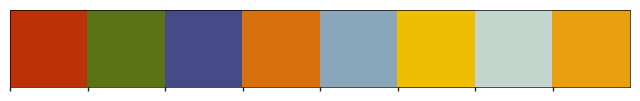

In [15]:
colors = met_brewer.met_brew(name="VanGogh2")
sns.palplot(colors)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


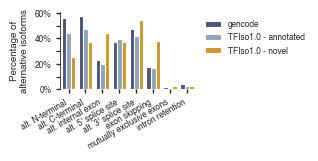

In [16]:
fig = plt.figure(figsize=(1.75, 1))

ax = sns.barplot(data=splicing_perc_melt, 
                 x="variable", 
                 y="value", 
                 hue="index", 
                 palette={"gencode": colors[2],
                          "TFIso1.0 - novel": colors[7],
                          "TFIso1.0 - annotated": colors[4]})
ax.set_xlabel("")
ax.set_xticklabels(list(splicing_perc_melt["variable"].unique()), 
                   ha="right", 
                   va="top", 
                   rotation=30)
ax.set_ylabel("Percentage of\nalternative isoforms")


plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.set_yticks(np.linspace(0, 0.6, 4))
ax.set_yticks(np.linspace(0, 0.6, 7), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])

fig.savefig("../../figures/fig2/splicing_cats.pdf", 
            dpi="figure", 
            bbox_inches="tight")

## 3. expression of novel isoforms compared to annotated ref/alt

using the same dummy, downsampled data as in fig1 for consistency

In [17]:
status_map = {}

# only loop through clone collection
for tf in clone_tfs.keys():
    gene = clone_tfs[tf]
    
    try:
        annot_ref = gene.reference_isoform.name
    except:
        annot_ref = "none"
        
    try:
        annot_alt = gene.alternative_isoforms
    except:
        annot_alt = []
        
    for iso in gene.cloned_isoforms:
        if iso.name == annot_ref:
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "ref"}
        elif iso.is_novel_isoform():
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "novel"}
        else:
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "alt"}

status_map = pd.DataFrame.from_dict(status_map, orient="index")
status_map

,gene_name,status
ZBTB18|1/2|04E08,ZBTB18,ref
ZBTB18|2/2|12E05,ZBTB18,alt
PRRX1|2/3|09F06,PRRX1,ref
PRRX1|1/3|09C07,PRRX1,alt
PRRX1|3/3|09H08,PRRX1,alt
...,...,...
HDX|2/2|09H10,HDX,novel
HSFY1|1/2|12F03,HSFY1,ref
HSFY1|2/2|11F06,HSFY1,alt
ZFY|1/2|06H10,ZFY,novel


In [18]:
vc = pd.DataFrame(status_map.status.value_counts())
vc

,count
status,
alt,333
novel,183
ref,177


In [19]:
print("NUM OF ISOFORMS IN TF1.0 THAT MATCH GENCODE ANNOTATIONS: %s" % (vc.loc[["alt", "ref"]]["count"].sum()))

NUM OF ISOFORMS IN TF1.0 THAT MATCH GENCODE ANNOTATIONS: 510


In [20]:
print("NUM OF ISOFORMS IN TF1.0 THAT ARE NOVEL: %s" % (vc.loc["novel"]["count"]))
print("PERCENT OF ISOFORMS IN TF1.0 THAT ARE NOVEL: %s" % (vc.loc["novel"]["count"]/vc["count"].sum()*100))

NUM OF ISOFORMS IN TF1.0 THAT ARE NOVEL: 183
PERCENT OF ISOFORMS IN TF1.0 THAT ARE NOVEL: 26.406926406926406


In [21]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


In [22]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


In [23]:
metadata_gtex_dummy = pd.read_table("../../data/processed/metadata_gtex_dummy.csv", sep=",", index_col=0)

# use same downsample as fig1
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

means_dev["median"] = means_dev.median(axis=1)
means_dev["max"] = means_dev.max(axis=1)

means_gtex_downsample["median"] = means_gtex_downsample.median(axis=1)
means_gtex_downsample["max"] = means_gtex_downsample.max(axis=1)

In [24]:
dev_mm = means_dev[["median", "max"]].reset_index()
gtex_ds_mm = means_gtex_downsample[["median", "max"]].reset_index()

In [25]:
dev_mm["clone_acc"] = dev_mm["UID"].str.split(" ", expand=True)[0]
gtex_ds_mm["clone_acc"] = gtex_ds_mm["UID"].str.split(" ", expand=True)[0]
mm = dev_mm[dev_mm["clone_acc"] != "noclone"].merge(gtex_ds_mm[gtex_ds_mm["clone_acc"] != "noclone"], 
                                                    on="clone_acc", suffixes=("_dev", "_gtex_ds"))

In [26]:
status_map = status_map.reset_index()
status_map["clone_acc"] = status_map["index"].str.split(" ", expand=True)[0]

exp_nov = status_map.merge(mm, on="clone_acc")
exp_nov_melt = pd.melt(exp_nov, id_vars=["index", "gene_name", "status", "clone_acc"], value_vars=["median_dev",
                                                                                                   "max_dev",
                                                                                                   "median_gtex_ds",
                                                                                                   "max_gtex_ds"])
exp_nov_melt["measurement"] = exp_nov_melt["variable"].str.split("_", expand=True)[0]

Palette 'Monet' has '9' discrete colors


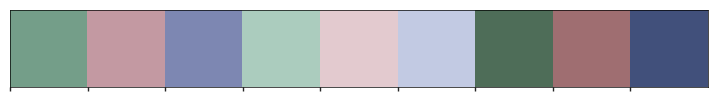

In [27]:
colors = met_brewer.met_brew(name="Monet")
sns.palplot(colors)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


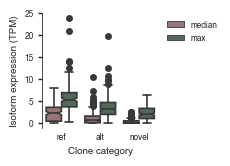

In [28]:
fig = plt.figure(figsize=(1.5, 1.5))

exp_nov_melt["value_log2"] = np.log2(exp_nov_melt["value"]+1)
ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("dev")], 
                 x="status", 
                 y="value", 
                 hue="measurement", 
                 palette={"median": colors[7],
                          "max": colors[6]}, 
                 flierprops={"marker": "o"}, 
                 fliersize=4, 
                 notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("Clone category")
ax.set_ylabel("Isoform expression (TPM)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

fig.savefig("../../figures/fig2/novel_isos.dev_expr_boxplot.pdf", 
            dpi="figure", 
            bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


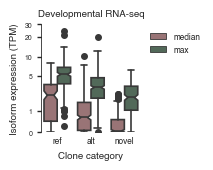

In [29]:
fig = plt.figure(figsize=(1.3, 1.4))

ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("dev")], 
                 x="status", 
                 y="value_log2", 
                 hue="measurement", 
                 palette={"median": colors[7],
                          "max": colors[6]}, 
                 flierprops={"marker": "o"}, 
                 fliersize=4, 
                 notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("Clone category")
ax.set_ylabel("Isoform expression (TPM)")

ticks = [0, 1, 5, 10, 20, 30]
ticklabels = [0, 1, 5, 10, 20, 30]
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='y', labelsize=fontsize-2)
ax.set_ylim(0, np.log2(31))
plt.title("Developmental RNA-seq")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

fig.savefig("../../figures/fig2/novel_isos.dev_expr_boxplot.log2.pdf", dpi="figure", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


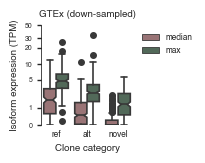

In [30]:
fig = plt.figure(figsize=(1.2, 1.3))

ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("gtex_ds")], 
                 x="status", 
                 y="value_log2", 
                 hue="measurement", 
                 palette={"median": colors[7],
                          "max": colors[6]}, 
                 flierprops={"marker": "o"}, 
                 fliersize=4, 
                 notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("Clone category")
ax.set_ylabel("Isoform expression (TPM)")
ticks = [0, 1, 5, 10, 20, 30, 50]
ticklabels = [0, 1, 5, 10, 20, 30, 50]
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)

ax.set_ylim(0, np.log2(51))
ax.tick_params(axis='y', labelsize=fontsize-2)
plt.title("GTEx (down-sampled)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

fig.savefig("../../figures/fig2/novel_isos.gtex_ds_expr_boxplot.log2.pdf", 
            dpi="figure", 
            bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


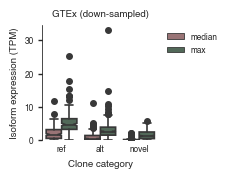

In [31]:
fig = plt.figure(figsize=(1.5, 1.5))

ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("gtex_ds")], 
                 x="status", y="value", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("Clone category")
ax.set_ylabel("Isoform expression (TPM)")


plt.title("GTEx (down-sampled)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_ylim(0, None)


fig.savefig("../../figures/fig2/novel_isos.gtex_ds_expr_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [32]:
dev_cols = [x for x in means_dev.columns if x not in ["UID", "median", "max"]]
means_dev["n_over1"] = (means_dev[dev_cols] >= 1).sum(axis=1)
means_dev["n_over5"] = (means_dev[dev_cols] >= 5).sum(axis=1)

dev_over = means_dev[["n_over1", "n_over5"]].reset_index()

dev_over["clone_acc"] = dev_over["UID"].str.split(" ", expand=True)[0]
dev_over = status_map.merge(dev_over, on="clone_acc")
dev_over_melt = pd.melt(dev_over, id_vars=["index", "gene_name", "status", "clone_acc", "UID"])
dev_over_melt.head()

,index,gene_name,status,clone_acc,UID,variable,value
0,ZBTB18|1/2|04E08,ZBTB18,ref,ZBTB18|1/2|04E08,ZBTB18|1/2|04E08 ZBTB18-201,n_over1,118
1,ZBTB18|2/2|12E05,ZBTB18,alt,ZBTB18|2/2|12E05,ZBTB18|2/2|12E05 ZBTB18-202,n_over1,120
2,PRRX1|2/3|09F06,PRRX1,ref,PRRX1|2/3|09F06,PRRX1|2/3|09F06 PRRX1-201,n_over1,93
3,PRRX1|1/3|09C07,PRRX1,alt,PRRX1|1/3|09C07,PRRX1|1/3|09C07 PRRX1-202,n_over1,51
4,PRRX1|3/3|09H08,PRRX1,alt,PRRX1|3/3|09H08,PRRX1|3/3|09H08 PRRX1-207,n_over1,63


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


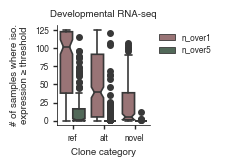

In [33]:
fig = plt.figure(figsize=(1.2, 1.3))

ax = sns.boxplot(data=dev_over_melt, 
                 x="status", y="value", hue="variable", palette={"n_over1": colors[7],
                                                                 "n_over5": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("Clone category")
ax.set_ylabel("# of samples where iso.\nexpression ≥ threshold")

plt.title("Developmental RNA-seq")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig2/novel_isos.dev_expr_boxplot.n_over_threshold.pdf", dpi="figure", bbox_inches="tight")

In [34]:
gtex_ds_cols = [x for x in means_gtex_downsample.columns if x not in ["UID", "median", "max"]]
means_gtex_downsample["n_over1"] = (means_gtex_downsample[gtex_ds_cols] >= 1).sum(axis=1)
means_gtex_downsample["n_over5"] = (means_gtex_downsample[gtex_ds_cols] >= 5).sum(axis=1)

gtex_ds_over = means_gtex_downsample[["n_over1", "n_over5"]].reset_index()

gtex_ds_over["clone_acc"] = gtex_ds_over["UID"].str.split(" ", expand=True)[0]
gtex_ds_over = status_map.merge(gtex_ds_over, on="clone_acc")
gtex_ds_over_melt = pd.melt(gtex_ds_over, id_vars=["index", "gene_name", "status", "clone_acc", "UID"])
gtex_ds_over.head()

,index,gene_name,status,clone_acc,UID,n_over1,n_over5
0,ZBTB18|1/2|04E08,ZBTB18,ref,ZBTB18|1/2|04E08,ZBTB18|1/2|04E08 ZBTB18-201,124,6
1,ZBTB18|2/2|12E05,ZBTB18,alt,ZBTB18|2/2|12E05,ZBTB18|2/2|12E05 ZBTB18-202,125,8
2,PRRX1|2/3|09F06,PRRX1,ref,PRRX1|2/3|09F06,PRRX1|2/3|09F06 PRRX1-201,113,26
3,PRRX1|1/3|09C07,PRRX1,alt,PRRX1|1/3|09C07,PRRX1|1/3|09C07 PRRX1-202,64,0
4,PRRX1|3/3|09H08,PRRX1,alt,PRRX1|3/3|09H08,PRRX1|3/3|09H08 PRRX1-207,65,0


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


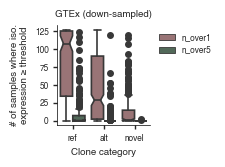

In [35]:
fig = plt.figure(figsize=(1.2, 1.3))

ax = sns.boxplot(data=gtex_ds_over_melt, 
                 x="status", y="value", hue="variable", palette={"n_over1": colors[7],
                                                                 "n_over5": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("Clone category")
ax.set_ylabel("# of samples where iso.\nexpression ≥ threshold")

plt.title("GTEx (down-sampled)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig2/novel_isos.gtex_ds_expr_boxplot.n_over_threshold.pdf", dpi="figure", bbox_inches="tight")

## 4. distribution of TF families in clone collection and assays v gencode

In [36]:
fam = load_tf_families()

In [37]:
len(genc_tfs)

1635

In [38]:
genc_df = {k: genc_tfs[k].GENCODE_isoforms for k in genc_tfs.keys()}
genc_df = {k: [v.name for v in values] for k, values in genc_df.items()}
genc_df = [(k, v) for k, sublist in genc_df.items() for v in sublist]
genc_df = pd.DataFrame(genc_df, columns=["gene", "isoform"])
genc_df['family'] = genc_df['gene'].map(fam)
genc_df.sample(5)

,gene,isoform,family
390,HOXD3,HOXD3-201,Homeodomain
1761,ZNF33A,ZNF33A-205,C2H2 ZF
1233,DMTF1,DMTF1-213,Myb/SANT
2083,HMGA2,HMGA2-205,AT hook
3804,ZNF671,ZNF671-203,C2H2 ZF


In [39]:
leave_separate = ["C2H2 ZF", "Homeodomain", "bHLH", "Nuclear receptor", "bZIP", "Forkhead", "Ets"]

In [40]:
def rename_family(row):
    if row.family in leave_separate:
        return row.family
    else:
        return "Other"
    
genc_df['family_renamed'] = genc_df.apply(rename_family, axis=1)
genc_df.sample(5)

,gene,isoform,family,family_renamed
1941,SOX6,SOX6-211,HMG/Sox,Other
3201,ZNF230,ZNF230-201,C2H2 ZF,C2H2 ZF
353,TLX2,TLX2-204,Homeodomain,Homeodomain
293,AHCTF1,AHCTF1-202,AT hook,Other
1028,RUNX2,RUNX2-210,Runt,Other


In [41]:
genc_vc = genc_df.groupby("family_renamed")["isoform"].agg("count").reset_index()
genc_vc["source"] = "GENCODE"
genc_vc

,family_renamed,isoform,source
0,C2H2 ZF,1840,GENCODE
1,Ets,89,GENCODE
2,Forkhead,97,GENCODE
3,Homeodomain,350,GENCODE
4,Nuclear receptor,176,GENCODE
5,Other,1179,GENCODE
6,bHLH,264,GENCODE
7,bZIP,149,GENCODE


In [42]:
clone_df = {k: clone_tfs[k].cloned_isoforms for k in clone_tfs.keys()}
clone_df = {k: [v.clone_acc for v in values] for k, values in clone_df.items()}
clone_df = [(k, v) for k, sublist in clone_df.items() for v in sublist]
clone_df = pd.DataFrame(clone_df, columns=["gene", "isoform"])
clone_df['family'] = clone_df['gene'].map(fam)
clone_df.sample(5)

,gene,isoform,family
622,ZNF175,ZNF175|1/3|12H06,C2H2 ZF
29,LHX9,LHX9|3/3|07A01,Homeodomain
26,PAX7,PAX7|3/4|03D09,Homeodomain; Paired box
627,ERF,ERF|1/2|12B11,Ets
407,SMAD9,SMAD9|2/2|02A11,SMAD


In [43]:
def rename_family(row):
    if row.family in leave_separate:
        return row.family
    else:
        return "Other"
    
clone_df['family_renamed'] = clone_df.apply(rename_family, axis=1)

In [44]:
order = clone_df.groupby("family")["isoform"].agg("count").reset_index()
order = order.sort_values(by="isoform", ascending=False)
xorder = list(order["family"])
yvals = list(order["isoform"])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


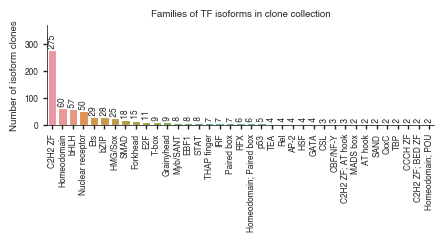

In [45]:
fig = plt.figure(figsize=(5, 1.3))

ax = sns.countplot(data=clone_df, x="family", order=xorder)
ax.set_xlabel("")
ax.set_ylabel("Number of isoform clones")
ax.set_title("Families of TF isoforms in clone collection")
ax.set_ylim((0, 370))

_= plt.xticks(rotation=90, ha='center', va="top")

for i, yval in enumerate(yvals):
    ax.text(i, yval, ' %s' % yval, ha='center', va='bottom', rotation=90, fontsize=6)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
fig.savefig("../../figures/fig2/clone_collection_families.all.pdf", dpi="figure", bbox_inches="tight")

In [46]:
clone_vc = clone_df.groupby("family_renamed")["isoform"].agg("count").reset_index()
clone_vc["source"] = "TFIso1.0"

In [47]:
y1h = load_y1h_pdi_data()
y1h['family'] = y1h['gene_symbol'].map(fam)
y1h['family_renamed'] = y1h.apply(rename_family, axis=1)

# limit to only clones considered in tf1.0, e.g. anything for a tf >1 iso
y1h = y1h[y1h["clone_acc"].isin(status_map["clone_acc"])]

y1h.sample(5)

,gene_symbol,clone_acc,HS1006,HS1022,HS1043,HS1067,HS1139,HS1142,HS118,HS1181,...,PF4V1,TNFSF10,TNFSF13,TNFSF14,TNFSF4,TNFSF8,XCL1,XCL2,family,family_renamed
155,WT1,WT1|2/6|12C12,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,C2H2 ZF,C2H2 ZF
48,HMGA1,HMGA1|2/2|10B11,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,AT hook,Other
108,PPARG,PPARG|1/4|10G02,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Nuclear receptor,Nuclear receptor
89,NFIX,NFIX|3/4|08F05,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SMAD,Other
187,STAT1,STAT1|5/7|03C01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,STAT,Other


In [48]:
baits = [x for x in y1h.columns if x not in ['gene_symbol', 'clone_acc', 'family', 'family_renamed',
                                             'any_true', 'all_na']]
print("NUMBER OF BAITS TESTED IN Y1H: %s" % len(baits))
print("number of new baits Anna's paired screen added: %s" % len([x for x in baits if not x.startswith("HS") and not x.startswith("MUT")]))
y1h['any_true'] = y1h[baits].sum(axis=1)
y1h['all_na'] = y1h[baits].isnull().values.all()

# remove any rows with allna values
y1h = y1h[~y1h['all_na']]
print("NUMBER OF ISOS SUCCESSFULLY TESTED IN Y1H: %s" % len(y1h))

NUMBER OF BAITS TESTED IN Y1H: 186
number of new baits Anna's paired screen added: 42
NUMBER OF ISOS SUCCESSFULLY TESTED IN Y1H: 171


In [49]:
y1h_vc = y1h.groupby("family_renamed")["clone_acc"].agg("count").reset_index()
y1h_vc.columns = ["family_renamed", "isoform"]
y1h_vc["source"] = "Y1H (all)"

In [50]:
y1h_any_vc = y1h[y1h['any_true'] > 0].groupby("family_renamed")["clone_acc"].agg("count").reset_index()
y1h_any_vc.columns = ["family_renamed", "isoform"]
y1h_any_vc["source"] = "Y1H (≥1 PDI)"

In [51]:
y2h = load_y2h_isoform_data(require_at_least_one_ppi_per_isoform=False)
y2h['family'] = y2h['ad_gene_symbol'].map(fam)
y2h['family_renamed'] = y2h.apply(rename_family, axis=1)

# limit to only clones considered in tf1.0, e.g. anything for a tf >1 iso
y2h = y2h[y2h["ad_clone_acc"].isin(status_map["clone_acc"])]

# remove any rows with na values
print(len(y2h))
y2h = y2h[~pd.isnull(y2h['Y2H_result'])]
print(len(y2h))

4354
4258


In [52]:
y2h_vc = y2h.groupby("family_renamed")["ad_clone_acc"].agg("count").reset_index()
y2h_vc.columns = ["family_renamed", "isoform"]
y2h_vc["source"] = "Y2H (all)"

In [53]:
y2h_any_vc = y2h[y2h["Y2H_result"] == True].groupby("family_renamed")["ad_clone_acc"].agg("count").reset_index()
y2h_any_vc.columns = ["family_renamed", "isoform"]
y2h_any_vc["source"] = "Y2H (≥1 PPI)"

In [54]:
m1h = load_m1h_activation_data()
m1h['M1H_mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
m1h['family'] = m1h['gene_symbol'].map(fam)
m1h['family_renamed'] = m1h.apply(rename_family, axis=1)

# limit to only clones considered in tf1.0, e.g. anything for a tf >1 iso
m1h = m1h[m1h["clone_acc"].isin(status_map["clone_acc"])]

m1h.sample(5)

,gene_symbol,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3,M1H_mean,family,family_renamed
146,NKX2-5,NKX2-5|1/3|01H01,1.272055,1.051122,0.909828,1.077668,Homeodomain,Homeodomain
36,EGR2,EGR2|1/2|01E03,3.094647,3.079103,2.809049,2.994266,C2H2 ZF,C2H2 ZF
330,ZNF473,ZNF473|1/2|10F12,7.125469,7.340258,7.204824,7.223517,C2H2 ZF,C2H2 ZF
601,ZNF614,ZNF614|3/4|05D08,-0.806812,-0.574664,-0.689290,-0.690255,C2H2 ZF,C2H2 ZF
38,ELF2,ELF2|2/4|04E01,2.827777,2.796233,2.611722,2.745244,Ets,Ets


In [55]:
print("NUM ISOS TESTED IN M1H: %s" % (len(m1h[~pd.isnull(m1h["M1H_mean"])].clone_acc.unique())))
print("NUM GENES TESTED IN M1H: %s" % (len(m1h[~pd.isnull(m1h["M1H_mean"])].gene_symbol.unique())))

NUM ISOS TESTED IN M1H: 580
NUM GENES TESTED IN M1H: 224


In [56]:
m1h_vc = m1h.groupby("family_renamed")["clone_acc"].agg("count").reset_index()
m1h_vc.columns = ["family_renamed", "isoform"]
m1h_vc["source"] = "M1H (all)"

In [57]:
m1h_any_vc = m1h[m1h["M1H_mean"].abs() > 1].groupby("family_renamed")["clone_acc"].agg("count").reset_index()
m1h_any_vc.columns = ["family_renamed", "isoform"]
m1h_any_vc["source"] = "M1H (≥2-fold activ.)"

In [58]:
mrg_vc = pd.concat([genc_vc, clone_vc, y1h_vc, y1h_any_vc, y2h_vc, y2h_any_vc, m1h_vc, m1h_any_vc])
mrg_vc

,family_renamed,isoform,source
0,C2H2 ZF,1840,GENCODE
1,Ets,89,GENCODE
2,Forkhead,97,GENCODE
3,Homeodomain,350,GENCODE
4,Nuclear receptor,176,GENCODE
...,...,...,...
3,Homeodomain,32,M1H (≥2-fold activ.)
4,Nuclear receptor,31,M1H (≥2-fold activ.)
5,Other,89,M1H (≥2-fold activ.)
6,bHLH,31,M1H (≥2-fold activ.)


In [59]:
mrg_piv = pd.pivot_table(mrg_vc, values="isoform", columns="source", index="family_renamed")
mrg_piv = mrg_piv.fillna(0)
mrg_piv = (mrg_piv/mrg_piv.sum(axis=0))*100
mrg_piv = mrg_piv.T
mrg_piv = mrg_piv.reindex(["GENCODE", "TFIso1.0", "Y1H (all)", "Y1H (≥1 PDI)",
                           "Y2H (all)", "Y2H (≥1 PPI)", "M1H (all)", "M1H (≥2-fold activ.)"])
mrg_piv = mrg_piv.reset_index()

mrg_piv = mrg_piv[["source", "Other", "Ets", "Forkhead", "bZIP", "Nuclear receptor",
                   "bHLH", "Homeodomain", "C2H2 ZF"]]
mrg_piv

family_renamed,source,Other,Ets,Forkhead,bZIP,Nuclear receptor,bHLH,Homeodomain,C2H2 ZF
0,GENCODE,28.450772,2.147683,2.340734,3.595560,4.247104,6.370656,8.445946,44.401544
1,TFIso1.0,25.829726,4.184704,2.164502,4.040404,7.215007,8.225108,8.658009,39.682540
2,Y1H (all),35.087719,2.923977,4.093567,1.169591,11.695906,9.941520,18.128655,16.959064
3,Y1H (≥1 PDI),32.173913,1.739130,3.478261,0.869565,16.521739,9.565217,19.130435,16.521739
4,Y2H (all),13.527478,0.211367,2.113668,3.029591,3.100047,40.793800,12.541099,24.682950
5,Y2H (≥1 PPI),15.182186,0.161943,1.983806,3.279352,3.643725,49.514170,10.931174,15.303644
6,M1H (all),25.000000,3.448276,2.413793,4.310345,7.931034,7.586207,9.137931,40.172414
7,M1H (≥2-fold activ.),26.099707,4.985337,3.225806,4.398827,9.090909,9.090909,9.384164,33.724340


Palette 'Hokusai1' has '7' discrete colors


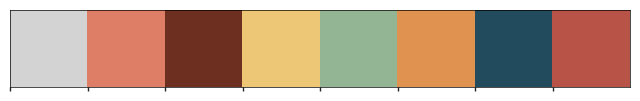

In [60]:
colors = met_brewer.met_brew(name="Hokusai1")
colors.append("lightgrey")
colors = colors[::-1]
#colors[7] = "lightgrey"
sns.palplot(colors)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


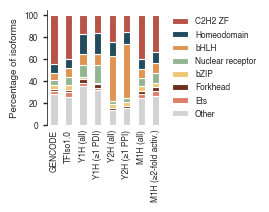

In [61]:
ax = mrg_piv.plot.bar(x="source", stacked=True, color=colors, figsize=(1.5, 1.5))

ax.set_ylabel("Percentage of isoforms")
ax.set_xlabel("")

plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

plt.savefig('../../figures/fig2/assay_families.detailed.pdf',
            bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


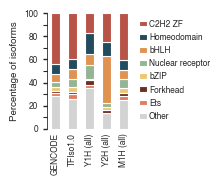

In [62]:
ax = mrg_piv[mrg_piv["source"].isin(["GENCODE", "TFIso1.0", "Y1H (all)",
                  "Y2H (all)", "M1H (all)"])].plot.bar(x="source", stacked=True, color=colors, figsize=(1.1, 1.5))

ax.set_ylabel("Percentage of isoforms")
ax.set_xlabel("")

plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=2, bbox_to_anchor=(1.01, 1), borderpad=0.25,
          handlelength=1, handletextpad=0.2, frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticks(range(0, 101, 10), minor=True)

plt.savefig('../../figures/fig2/assay_families.pdf',
            bbox_inches='tight')

## 5. print number of genes/isos in each category for use in schematic figs/text

In [63]:
print("total # of isos in collection")
len(clone_df)

total # of isos in collection


693

In [64]:
print("total # of unique TF genes in collection")
len(clone_df.gene.unique())

total # of unique TF genes in collection


246

In [65]:
print("total # of isos tested in Y1H")
len(y1h)

total # of isos tested in Y1H


171

In [66]:
print("total # of unique TF genes tested in Y1H")
len(y1h.gene_symbol.unique())

total # of unique TF genes tested in Y1H


80

In [67]:
print("total # of baits tested in Y1H")
len(baits)

total # of baits tested in Y1H


186

In [68]:
print("total # of isos with at least 1 interaction in Y1H")
len(y1h[y1h['any_true'] > 0])

total # of isos with at least 1 interaction in Y1H


115

In [69]:
print("total # of unique TF genes with at least 1 interaction in Y1H")
len(y1h[y1h['any_true'] > 0].gene_symbol.unique())

total # of unique TF genes with at least 1 interaction in Y1H


69

In [70]:
print("total # of isos tested in Y2H")
len(y2h[~pd.isnull(y2h["Y2H_result"])].ad_clone_acc.unique())

total # of isos tested in Y2H


253

In [71]:
print("total # of unique TF genes tested in Y2H")
len(y2h[~pd.isnull(y2h["Y2H_result"])].ad_gene_symbol.unique())

total # of unique TF genes tested in Y2H


87

In [72]:
print("total # of partners tested in Y2H")
len(y2h.db_gene_symbol.unique())

total # of partners tested in Y2H


538

In [73]:
print("total # of isos with at least 1 interaction in Y2H")
len(y2h[y2h["Y2H_result"] == True].ad_clone_acc.unique())

total # of isos with at least 1 interaction in Y2H


193

In [74]:
print("total # of unique TF genes with at least 1 interaction in Y2H")
len(y2h[y2h["Y2H_result"] == True].ad_gene_symbol.unique())

total # of unique TF genes with at least 1 interaction in Y2H


87

In [75]:
print("total # of isos tested in M1H")
len(m1h.clone_acc.unique())

total # of isos tested in M1H


580

In [76]:
print("total # of unique TF genes tested in M1H")
len(m1h.gene_symbol.unique())

total # of unique TF genes tested in M1H


224

In [77]:
print("total # of isos with activity in M1H (abs > 1)")
len(m1h[m1h["M1H_mean"].abs() > 1].clone_acc.unique())

total # of isos with activity in M1H (abs > 1)


341

In [78]:
print("total # of unique TF genes with activity in M1H (abs > 1)")
len(m1h[m1h["M1H_mean"].abs() > 1].gene_symbol.unique())

total # of unique TF genes with activity in M1H (abs > 1)


165

In [79]:
all_3 = set(m1h[m1h["M1H_mean"].abs() > 1].gene_symbol.unique()).intersection(set(y2h[y2h["Y2H_result"] == True].ad_gene_symbol.unique())).intersection(set(y1h[y1h['any_true'] > 0].gene_symbol.unique()))
all_3

{'E2F3',
 'ESRRG',
 'FOXJ2',
 'GMEB1',
 'HNF4A',
 'LHX6',
 'LHX9',
 'MEIS1',
 'MEIS2',
 'MEOX1',
 'NFIA',
 'NFIX',
 'NR4A2',
 'PATZ1',
 'PAX5',
 'PBX1',
 'PKNOX1',
 'PPARG',
 'PRRX1',
 'RARG',
 'RBPJ',
 'RFX4',
 'STAT3',
 'TCF12',
 'TCF4',
 'WT1',
 'ZBTB18',
 'ZNF143',
 'ZNF18'}

## 6. compare novel isoform performance in assay to annotated ref/alt

In [80]:
from data_loading import load_valid_isoform_clones

In [81]:
mane_select_clones = {tf.MANE_select_isoform.clone_acc for tf in clone_tfs.values() 
                      if tf.cloned_MANE_select_isoform}

In [82]:
iso = load_valid_isoform_clones()
iso['is_longest_isoform'] = iso['clone_acc'].isin(iso.sort_values('num_aa', 
                                                                  ascending=False).groupby('gene_symbol').nth(0)['clone_acc'].values)
iso['category'] = 'alternative'
iso.loc[iso['clone_acc'].isin(mane_select_clones), 'category'] = 'reference'
iso.loc[iso['is_novel_isoform'], 'category'] = 'novel'

# this df includes some stuff we filtered out - remove these
iso = iso[iso["clone_acc"].isin(clone_df["isoform"])]

In [83]:
len(iso['gene_symbol'].unique())

246

In [84]:
genes_w_ref = list(iso[iso['category'] == 'reference']['gene_symbol'].unique())
len(genes_w_ref)

165

In [85]:
# subset iso df to only genes w MANE select isoform
iso_sub = iso[iso['gene_symbol'].isin(genes_w_ref)]
len(iso_sub)

464

In [86]:
iso_sub['valid_ppi_test'] = iso['clone_acc'].map(y2h.groupby('ad_clone_acc').apply(lambda rows: ((rows['Y2H_result'] == True) |
                                                                                                 (rows['Y2H_result'] == False))
                                                                                                 .any()))

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_88598/904820016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_sub['valid_ppi_test'] = iso['clone_acc'].map(y2h.groupby('ad_clone_acc').apply(lambda rows: ((rows['Y2H_result'] == True) |


In [87]:
iso_sub['at_least_one_ppi'] = iso['clone_acc'].map(y2h.groupby('ad_clone_acc').apply(lambda rows: ((rows['Y2H_result'] == True))
                                                                                                    .any()))

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_88598/380360055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_sub['at_least_one_ppi'] = iso['clone_acc'].map(y2h.groupby('ad_clone_acc').apply(lambda rows: ((rows['Y2H_result'] == True))


In [88]:
y1h = y1h.drop_duplicates('clone_acc')
iso_sub['at_least_one_pdi'] = iso_sub['clone_acc'].map(y1h.set_index('clone_acc')['any_true'] > 0)

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_88598/1046099652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_sub['at_least_one_pdi'] = iso_sub['clone_acc'].map(y1h.set_index('clone_acc')['any_true'] > 0)


In [89]:
iso_sub['at_least_two_fold_activation'] = iso_sub['clone_acc'].map(
                                            m1h.set_index('clone_acc')['M1H_mean'].abs() > 1)

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_88598/1886791230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_sub['at_least_two_fold_activation'] = iso_sub['clone_acc'].map(


In [90]:
iso_sub.category.value_counts()

category
alternative    209
reference      165
novel           90
Name: count, dtype: int64

Palette 'Monet' has '9' discrete colors


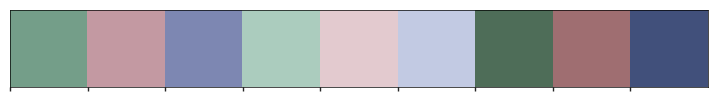

In [91]:
colors = met_brewer.met_brew(name="Monet")
sns.palplot(colors)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


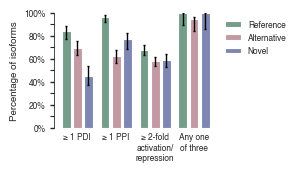

In [92]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.1, h=1.5)
cats = ['reference', 'alternative', 'novel']
positives = []
tested = []

for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_one_pdi'].sum())
    tested.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_one_pdi'].notnull().sum())
    
for cat in cats:
    positives.append(iso_sub.loc[iso_sub['valid_ppi_test'] &
                        (iso_sub['category'] == cat),
                        'at_least_one_ppi'].sum())
    tested.append(iso_sub.loc[iso_sub['valid_ppi_test'] &
                        (iso_sub['category'] == cat),
                        'at_least_one_ppi'].notnull().sum())

for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_two_fold_activation'].sum())
    tested.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_two_fold_activation'].notnull().sum())
for cat in cats:
    tested_iso = (iso_sub['valid_ppi_test'] & 
                    iso_sub['at_least_two_fold_activation'].notnull() &
                    iso_sub['at_least_one_pdi'].notnull() &
                    (iso_sub['category'] == cat))
    positives.append((iso_sub.loc[tested_iso, 'at_least_one_ppi'] |
                 iso_sub.loc[tested_iso, 'at_least_two_fold_activation'] |
                 iso_sub.loc[tested_iso, 'at_least_one_pdi']).sum())
    tested.append(tested_iso.sum())
    
vals = [p / n for p, n in zip(positives, tested)]
#errs = [np.sqrt(((p / n) * (1 - (p / n)) / n)) for p, n in zip(positives, tested)]

pos = np.array(positives)
neg = np.array(tested) - pos
fracs = np.array(vals)
intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
errs = [fracs - intv[0], intv[1] - fracs]
errs[0][pos == 0] = 0.
errs[1][neg == 0] = 0.

offset = 0.5
x_pos = ([i for i in range(3)] + 
       [i + offset for i in range(3, 6)] + 
       [i + offset * 2 for i in range(6, 9)] +
       [i + offset * 3 for i in range(9, 12)])


ax.bar(x=x_pos, height=vals, color=[colors[0], colors[1], colors[2]] * 3)
ax.errorbar(x=x_pos, y=vals, yerr=errs,
            color='black',
            fmt='none',
            linewidth=1,
            capsize=1)
ax.set_ylim(0, 1.1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)

ax.legend([Patch(facecolor=colors[i]) for i in range(3)],
        ['Reference', 'Alternative', 'Novel'],
        loc='upper left',
        bbox_to_anchor=(1, 1),
        frameon=False,
)

ax.set_xticks([x_pos[i] for i in [1, 4, 7, 10]])
ax.set_xticklabels([
   '≥ 1 PDI',
   '≥ 1 PPI',
   '≥ 2-fold\nactivation/\nrepression',
   'Any one\nof three',
], 
                    ha='center',
                    fontsize=6,
                    )


ax.set_ylabel('Percentage of isoforms')
ax.set_ylim(0, 1)

fig.savefig('../../figures/fig2/at-least-some-assay-result_ref-vs-alt-vs-novel_bar.pdf',
            bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


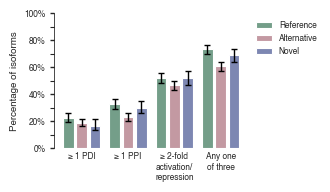

In [93]:

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.5, h=1.75)
cats = ['reference', 'alternative', 'novel']
positives = []
tested = []

for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_one_pdi'].sum())

for cat in cats:
    positives.append(iso_sub.loc[iso_sub['valid_ppi_test'] &
                        (iso_sub['category'] == cat),
                        'at_least_one_ppi'].sum())

for cat in cats:
    positives.append(iso_sub.loc[
                        (iso_sub['category'] == cat),
                        'at_least_two_fold_activation'].sum())

for cat in cats:
    positives.append((iso_sub.loc[(iso_sub['category'] == cat), 'at_least_one_ppi'].fillna(False) |
                      iso_sub.loc[(iso_sub['category'] == cat), 'at_least_two_fold_activation'].fillna(False) |
                      iso_sub.loc[(iso_sub['category'] == cat), 'at_least_one_pdi'].fillna(False)).sum())    

tested = [(iso_sub['category'] == cat).sum() for cat in cats] * 4
vals = [p / n for p, n in zip(positives, tested)]

pos = np.array(positives)
neg = np.array(tested) - pos
fracs = np.array(vals)
intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
errs = [fracs - intv[0], intv[1] - fracs]
errs[0][pos == 0] = 0.
errs[1][neg == 0] = 0.

offset = 0.5
x_pos = ([i for i in range(3)] + 
       [i + offset for i in range(3, 6)] + 
       [i + offset * 2 for i in range(6, 9)] +
       [i + offset * 3 for i in range(9, 12)])
ax.bar(x=x_pos, height=vals, color=[colors[0], colors[1], colors[2]] * 3)
ax.errorbar(x=x_pos, y=vals, yerr=errs,
            color='black',
            fmt='none',
            capsize=2,
            linewidth=1)
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)

ax.legend([Patch(facecolor=colors[i]) for i in range(3)],
        ['Reference', 'Alternative', 'Novel'],
        loc='upper left',
        bbox_to_anchor=(1, 1),
        frameon=False,
)

ax.set_ylabel('Percentage of isoforms')

ax.set_xticks([x_pos[i] for i in [1, 4, 7, 10]])
ax.set_xticklabels([
   '≥ 1 PDI',
   '≥ 1 PPI',
   '≥ 2-fold\nactivation/\nrepression',
   'Any one\nof three',
], 
                    ha='center',
                    fontsize=6,
                    )


fig.savefig('../../figures/fig2/at-least-some-assay-result_ref-vs-alt-vs-novel_absolute_bar.pdf',
            bbox_inches='tight')

## 7. make validation figures for Y2H (N2H)

In [94]:
df = load_n2h_ppi_validation_data()
print(len(df))
df.head()

821


,test_orf_ida,test_orf_idb,test_pla,test_pos_pair,score_pair,pair,source,test_pos_empty-N1,score_empty-N1,test_pos_empty-N2,score_empty-N2,clone_acc,gene_symbol_tf,gene_symbol_partner,NLR,log2 NLR,score_pair_log10,score_empty-N1_log10,score_empty-N2_log10
0,54731,101256,1,A01,8351.0,54731_101256,vignettes,A03,137.0,A02,501.0,ATF2|2/6|09E05,ATF2,ATF2,16.668663,4.059066,3.921738,2.136721,2.699838
1,12504,101256,1,A04,6709.0,12504_101256,vignettes,A03,137.0,A05,6709.0,ATF2|2/6|09E05,ATF2,FOSL2,1.000000,0.000000,3.826658,2.136721,3.826658
2,10051,101256,1,A06,30279.0,10051_101256,vignettes,A03,137.0,A07,7094.0,ATF2|2/6|09E05,ATF2,MAPK9,4.268255,2.093646,4.481142,2.136721,3.850891
3,12504,101240,1,A11,91959.0,12504_101240,vignettes,A10,158.0,A05,6709.0,CREB5|1/3|08E11,CREB5,FOSL2,13.706812,3.776821,4.963594,2.198657,3.826658
4,5718,101240,1,B03,1071.0,5718_101240,RRS - TF space specific,A10,158.0,B04,391.0,CREB5|1/3|08E11,CREB5,NPPA,2.739130,1.453718,3.029789,2.198657,2.592177


In [95]:
df['source'].value_counts()

source
RRS - from HuRI               157
isoform negatives             131
isoform positives             131
RRS - hRRS-v2                  78
Lit-BM-13                      75
RRS - TF space specific        71
Lit-BM - TF space specific     62
PRS - hPRS-v2                  60
vignettes                      56
Name: count, dtype: int64

In [96]:
COLOR_LIT = (60 / 255, 134 / 255, 184 / 255)
COLOR_HURI = (155 / 255, 97 / 255, 153 / 255)
colors = {'vignettes': 'yellow', 
          'isoform positives': COLOR_HURI,
          'RRS - TF space specific': 'tab:red',
          'Lit-BM - TF space specific': COLOR_LIT,
          'isoform negatives': 'grey',
          'RRS - from HuRI': 'tab:red',
          'Lit-BM-13': COLOR_LIT,
          'PRS - hPRS-v2': COLOR_LIT,
          'RRS - hRRS-v2': 'tab:red'}

In [97]:
sources = ['PRS - hPRS-v2', 
           'RRS - hRRS-v2',
           'isoform positives', 
           'isoform negatives']

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


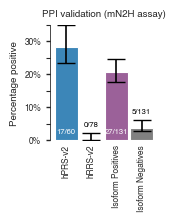

In [98]:
# bar chart
df['result'] = df['NLR'] > df.loc[df['source'] == 'RRS - hRRS-v2', 'NLR'].max()

fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.5))
validation_plot(data=df,
                selections=[df['source'] == x for x in sources],
                labels=[str(x) for x in sources],
                colors=[colors[x] for x in sources],
                result_column='result',
                errorbar_capsize=0.175,
                y_max=0.35,
                xlabel_rotation=90,
                bar_spacing=0.07,
                draw_numbers=True,
                fontsize=PAPER_FONTSIZE-1.5)
#ax.set_xticklabels(sources, ha="right", va="top", rotation=30)
rename_sources = {
           'PRS - hPRS-v2': 'hPRS-v2', 
           'RRS - hRRS-v2': 'hRRS-v2',
           'isoform positives': 'Isoform Positives', 
           'isoform negatives': 'Isoform Negatives',
}
ax.set_xticklabels([rename_sources[s] for s in sources])
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
ax.set_title("PPI validation (mN2H assay)")

for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('Percentage positive')

fig.savefig('../../figures/fig2/N2H_barplot.pdf', dpi="figure", bbox_inches='tight')

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_88598/1857788443.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


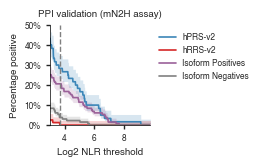

In [99]:
line_styles = ['-', '-', '-', '-']
fig, ax = plt.subplots(1, 1, figsize=(1.3, 1.3))
validation_titration_plot(data=df, 
                          selections=[df['source'] == x for x in sources],
                          labels=[rename_sources[s] for s in sources],
                          colors=[colors[x] for x in sources],
                          line_styles=line_styles,
                          score_column='log2 NLR',
                          threshold=df.loc[df['source'] == 'RRS - hRRS-v2', 'log2 NLR'].max(),
                          xmin=3,
                          ax=ax)
ax.set_xlabel('Log2 NLR threshold')
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

for loc in ['top', 'right']:
    ax.spines[loc].set_visible(False)

ax.set_title("PPI validation (mN2H assay)")
ax.set_ylim(0, 0.5)
ax.set_ylabel('Percentage positive')

fig.savefig('../../figures/fig2/TFv02_titration.pdf',
            bbox_inches='tight')

## 8. make validation figures for Y1H (luciferase)

In [100]:
df = load_PDI_luciferase_validation_experiment()

In [101]:
df['Set'].value_counts()

Set
eY1Hvalidation    141
Name: count, dtype: int64

In [102]:
print('In PDI validation experiment, tested:')
print(df['gene_symbol'].nunique(), 'different TF genes')
print(df['clone_acc'].nunique(), 'different TF isoforms')
print(df['Bait'].nunique(), 'different baits')
print(df.shape[0], 'total PDIs')

In PDI validation experiment, tested:
19 different TF genes
48 different TF isoforms
41 different baits
141 total PDIs


In [103]:
df.head()

,Set,Interaction?,Bait,gene_symbol,clone_acc,Plate-well,Replicate1,Replicate2,Replicate3,Average (empty-pEZY3-VP160),Foldchange1,Foldchange2,Foldchange3,Average,Log2(FC),Y1H_positive
0,eY1Hvalidation,no,HS281,DLX1,DLX1|2/2|07E09,18-C4,0.088103,0.097955,0.088123,0.186988,0.471169,0.523857,0.471278,0.488768,-1.032779,False
1,eY1Hvalidation,no,HS598,DLX1,DLX1|2/2|07E09,12-G5,0.143830,0.132734,0.132411,0.218959,0.656880,0.606203,0.604731,0.622604,-0.683612,False
2,eY1Hvalidation,no,HS1419,DLX4,DLX4|3/3|10B05,13-B10,0.067359,0.064723,0.067650,0.081857,0.822884,0.790680,0.826442,0.813335,-0.298078,False
3,eY1Hvalidation,no,HS281,DLX4,DLX4|3/3|10B05,18-C7,0.111438,0.122384,0.104692,0.186988,0.595966,0.654504,0.559885,0.603452,-0.728690,False
4,eY1Hvalidation,no,HS281,DLX4,DLX4|1/3|11A04,18-C5,5.834440,5.667983,5.528556,0.186988,31.202254,30.312047,29.566401,30.360234,4.924111,False


In [104]:
# update the interaction calls if needed
new_calls = []
for i, row in df.iterrows():
    clone = row['clone_acc']
    bait = row['Bait']
    orig_y1h_call = row['Interaction?']
    
    try:
        updated_y1h_call = y1h[y1h['clone_acc'] == clone][bait].iloc[0]
    except:
        print("not found: clone: %s | bait: %s | orig call: %s" % (clone, bait, orig_y1h_call))
        updated_y1h_call = np.nan
    new_calls.append(updated_y1h_call)

not found: clone: HNF1B|4/4|05E06 | bait: HS565 | orig call: no
not found: clone: HNF4A|6/6|10F07 | bait: HS1315 | orig call: no
not found: clone: HNF4A|6/6|10F07 | bait: HS20 | orig call: no
not found: clone: LCOR|1/2|09G02 | bait: HS118 | orig call: no
not found: clone: LCOR|1/2|09G02 | bait: HS586 | orig call: no
not found: clone: SOX15|2/2|08F12 | bait: HS1181 | orig call: no
not found: clone: SOX15|2/2|08F12 | bait: HS796 | orig call: no
not found: clone: TBX6|2/2|01F02 | bait: HS416 | orig call: no
not found: clone: THRA|3/3|09B09 | bait: HS1185 | orig call: no
not found: clone: THRA|3/3|09B09 | bait: HS204 | orig call: no
not found: clone: HNF1B|4/4|05E06 | bait: HS863 | orig call: yes
not found: clone: LCOR|1/2|09G02 | bait: HS1022 | orig call: yes
not found: clone: LCOR|2/2|12B05 | bait: HS1022 | orig call: yes
not found: clone: LCOR|2/2|12B05 | bait: HS118 | orig call: yes
not found: clone: LCOR|2/2|12B05 | bait: HS586 | orig call: yes
not found: clone: SOX15|1/2|11D03 | bait

In [105]:
df["updated_y1h_call"] = new_calls
df.updated_y1h_call.value_counts(dropna=False)

updated_y1h_call
True     63
False    44
NaN      20
<NA>     14
Name: count, dtype: int64

In [106]:
# remove any updated calls that became NaN
df_nn = df[~pd.isnull(df['updated_y1h_call'])]

In [107]:
print('In PDI validation experiment, tested (updated w new calls):')
print(df_nn['gene_symbol'].nunique(), 'different TF genes')
print(df_nn['clone_acc'].nunique(), 'different TF isoforms')
print(df_nn['Bait'].nunique(), 'different baits')
print(df_nn.shape[0], 'total PDIs')

In PDI validation experiment, tested (updated w new calls):
16 different TF genes
39 different TF isoforms
37 different baits
107 total PDIs


In [108]:
print('Isoforms per gene:')
df_nn.groupby(['gene_symbol'])['clone_acc'].nunique().value_counts().sort_index()

Isoforms per gene:


clone_acc
1    1
2    7
3    8
Name: count, dtype: int64

In [109]:
print('Baits per isoform:')
df_nn.groupby(['clone_acc'])['Bait'].nunique().value_counts().sort_index()

Baits per isoform:


Bait
1     4
2    12
3    13
4    10
Name: count, dtype: int64

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_88598/2052713453.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x='updated_y1h_call', y='Log2(FC)', ax=ax, order=[True, False],
/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_88598/2052713453.py:3: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.stripplot(data=df, x='updated_y1h_call', y='Log2(FC)', ax=ax, order=[True, False],
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


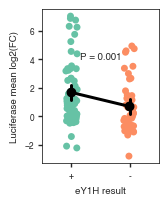

In [110]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2.)
sns.stripplot(data=df, x='updated_y1h_call', y='Log2(FC)', ax=ax, order=[True, False], 
              palette=sns.color_palette("Set2"), zorder=1)
sns.pointplot(data=df, x='updated_y1h_call', y='Log2(FC)', ax=ax, order=[True, False],
              color='black')
effectsize, pvalue = stats.ttest_ind(df.loc[df['Y1H_positive'], 'Log2(FC)'].values,
                df.loc[~df['Y1H_positive'], 'Log2(FC)'].values)
ax.text(x=0.5, y=4, s='P = {:.1}'.format(pvalue), ha='center')
ax.set_xlabel('eY1H result')
ax.set_xticklabels(['+', '-'])
ax.set_ylabel('Luciferase mean log2(FC)')
fig.savefig('../../figures/fig2/PDI-luciferase_validation_point-plot.pdf',
            bbox_inches='tight')

In [111]:
df.updated_y1h_call.value_counts()

updated_y1h_call
True     63
False    44
Name: count, dtype: int64

In [112]:
df.Y1H_positive.value_counts()

Y1H_positive
True     86
False    55
Name: count, dtype: int64

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


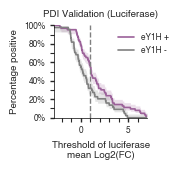

In [113]:
# titration plot of positive vs negative
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.2, h=1.2)
validation_titration_plot(data=df_nn,
                          selections=[df_nn['updated_y1h_call'], 
                                      ~df_nn['updated_y1h_call']],
                          score_column='Log2(FC)',
                          labels=['eY1H +', 'eY1H -'],
                          colors=[COLOR_HURI, 'grey'],
                          ax=ax)
ax.set_xlabel('Threshold of luciferase\nmean Log2(FC)')
plt.legend(loc=2, frameon=False, bbox_to_anchor=(0.6, 1))

for loc in ['top', 'right']:
    ax.spines[loc].set_visible(False)

ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
ax.set_ylim(0, 1)
ax.set_ylabel('Percentage positive')
ax.axvline(x=1, color='grey', linestyle='--', lw=1)
ax.set_xticks(range(-2, 7), minor=True)
ax.set_title("PDI Validation (Luciferase)")
    
fig.savefig('../../figures/fig2/PDI-luciferase_validation_titration-plot.pdf',
            bbox_inches='tight')

In [114]:
def p_value(row):
    a = row[['Replicate1', 'Replicate2', 'Replicate3']].values
    b = row['Average (empty-pEZY3-VP160)']
    
    # this code doesn't work on kaia's env; need to update scipy which requires updating to py3.7
    #pval = stats.ttest_1samp(list(a), b, alternative='greater').pvalue
    
    # return two-sided pval * 2 for now
    pval = stats.ttest_1samp(list(a), b).pvalue * 2
    
    return pval

df['p-value'] = df.apply(p_value, axis=1)

In [115]:
df['positive'] = (df['p-value'] < 0.05) & (df['Log2(FC)'] >= 1)

In [116]:
df.groupby('Interaction?')['positive'].mean()

Interaction?
no     0.290909
yes    0.569767
Name: positive, dtype: float64

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


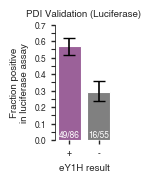

In [117]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=0.75, h=1.5)
validation_plot(data=df,
                selections=[df['Y1H_positive'], 
                           ~df['Y1H_positive']],
                result_column='positive',
                labels=['+', '-'],
                colors=[COLOR_HURI, 'grey'],
                errorbar_capsize=0.25,
                ax=ax,
                fontsize=PAPER_FONTSIZE-1)
ax.set_ylim(0, 0.7)
ax.set_xlabel('eY1H result')
ax.set_ylabel('Fraction positive\nin luciferase assay')

ax.set_title("PDI Validation (Luciferase)")

for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
    
fig.savefig('../../figures/fig2/Luciferase_barplot.pdf', bbox_inches='tight', dpi='figure')

## 9. make reproducibility figure for M1H

In [118]:
m1h.head()

,gene_symbol,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3,M1H_mean,family,family_renamed
360,AEBP2,AEBP2|2/3|05F03,0.241019,0.189211,0.473661,0.301297,C2H2 ZF,C2H2 ZF
359,AEBP2,AEBP2|3/3|05E07,-0.276303,-0.305477,-0.121186,-0.234322,C2H2 ZF,C2H2 ZF
0,ARNT2,ARNT2|1/6|08C12,4.498733,4.501519,4.297244,4.432498,bHLH,bHLH
1,ARNT2,ARNT2|2/6|09E01,2.407721,2.407411,2.197963,2.337698,bHLH,bHLH
3,ARNTL2,ARNTL2|2/5|12C06,0.398027,0.391809,0.299461,0.363099,bHLH,bHLH


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


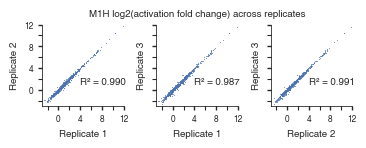

In [119]:
fig, axs = plt.subplots(ncols=3, 
                        nrows=1, 
                        sharey=True)
fig.set_size_inches(w=4, h=1.5)
m1h_min = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].min().min()
m1h_max = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].max().max()
m1h_min = -3
m1h_max = 12

for i, (a, b) in enumerate([('1', '2'), ('1', '3'), ('2', '3')]):
    axs[i].scatter(x=m1h[f'M1H_rep{a}'].values,
            y=m1h[f'M1H_rep{b}'].values,
                alpha=0.8,
                s=0.6,
                linewidth=0,
            )
    r = stats.pearsonr(m1h[f'M1H_rep{a}'].values, m1h[f'M1H_rep{b}'].values)[0]
    axs[i].text(s=f"R² = {r**2:.3f}",
                x=4, 
                y=1)
    axs[i].set_xlabel(f'Replicate {a}')
    axs[i].set_ylabel(f'Replicate {b}')


for ax in axs:
    ax.set_ylim(m1h_min, m1h_max)
    ax.set_xlim(m1h_min, m1h_max)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal')
    ax.set_yticks(range(0, 13, 4))
    ax.set_yticks(range(-2, 13, 2), minor=True)
    ax.set_xticks(range(0, 13, 4))
    ax.set_xticks(range(-2, 13, 2), minor=True)

# same ticks
axs[1].set_title('M1H log2(activation fold change) across replicates')
plt.subplots_adjust(wspace=0.4)
fig.savefig("../../figures/fig2/M1H_replicate_scatter.pdf", 
            bbox_inches="tight", 
            dpi="figure")

## 9. make tables needed for cytoscape network fig

In [120]:
# # table of edges
# #    - clone to (edge + clone_id) + to duplicate
# # table of nodes
# #    - clone to gene
# #    - dna vs isoform vs 

# ppi = load_full_y2h_data_including_controls()
# ppi = ppi.loc[(ppi['category'] == 'tf_isoform_ppis') &
#               (ppi['Y2H_result'] == True),
#               ['ad_clone_acc', 'ad_gene_symbol', 'db_gene_symbol']]
# ppi = ppi.rename(columns={'ad_clone_acc': 'isoform',
#                           'db_gene_symbol': 'partner'})
# ppi['partner'] = ppi['partner'] + '-' + ppi['ad_gene_symbol']
# pdi = pd.read_csv('../../data/internal/a2_juan_pdi_w_unique_isoacc.tsv', sep='\t')
# clones = load_valid_isoform_clones()
# pdi = pdi.loc[pdi['unique_acc'].isin(clones['clone_acc']), :]
# pdi['partner'] = pdi['bait'] + '-' + pdi['tf']
# pdi['isoform'] = pdi['unique_acc']
# edges = pd.concat([ppi.loc[:, ['isoform', 'partner']],
#                    pdi.loc[:, ['isoform', 'partner']]])
# edges.to_csv('../../output/edges.tsv', sep='\t', index=False)

# clones = clones.rename(columns={'clone_acc': 'node_id'})
# clones['type'] = 'isoform'
# dna = pd.DataFrame(data=pdi['partner'].unique(), columns=['node_id'])
# dna['type'] = 'DNA'
# proteins = pd.DataFrame(data=ppi['partner'].unique(), columns=['node_id'])
# proteins['type'] = 'Protein'
# nodes = pd.concat([clones, proteins, dna], sort=True)
# nodes.to_csv('../../output/node_table.tsv', sep='\t', index=False)

## 10. make example expression plot for ZNF414

In [121]:
def developmental_tissue_expression_plot(gene_name, figsize, ylim, means, cols, fig_suffix):
    locs = [x for x in list(means.index) if x.split("|")[0] == gene_name]
    
    # include isos that aren't cloned
    locs = list(set(locs + [x for x in list(means.index) if x.split(" ")[1][:-4] == gene_name]))
    
    n_isos = len(means.loc[locs])
    palette = met_brewer.met_brew(name="Egypt")
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[locs, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[locs, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_ylabel('log2(TPM + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('Percentage of\ngene expression')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False)
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../../figures/fig2/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_88598/1624762615.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])


Palette 'Egypt' has '4' discrete colors


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


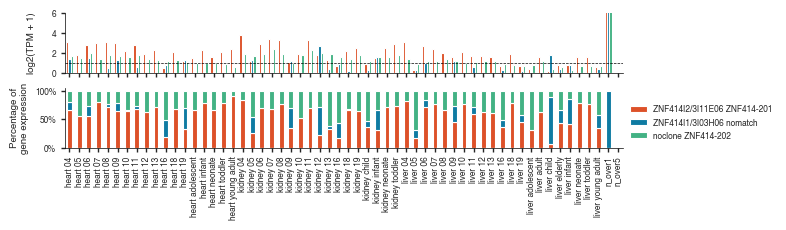

In [122]:
notestis_cols = [x for x in means_dev.columns if "testis" not in x]
notestis_cols = [x for x in notestis_cols if "median" not in x]
notestis_cols = [x for x in notestis_cols if "max" not in x]
notestis_cols = [x for x in notestis_cols if "ovary" not in x]
notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("ZNF414", (7.2, 1.75), (0, 6), means_dev, notestis_cols, 
                                     "means_dev_notestis_large")

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_88598/1624762615.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


Palette 'Egypt' has '4' discrete colors


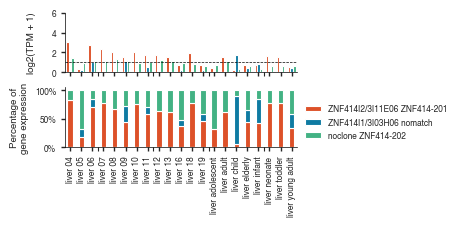

In [123]:
liver_cols = [x for x in means_dev.columns if "liver" in x]
developmental_tissue_expression_plot("ZNF414", (3, 1.75), (0, 6), means_dev, liver_cols, 
                                     "means_dev_liver_large")

## 11. make alphafold disorder plots

In [124]:
# dssp_dir = Path('../../data/processed/dssp_alphafold')
# dfs = []
# for dssp_file_path in dssp_dir.iterdir():
#     dssp = make_dssp_dict(dssp_file_path)
#     dfs.append(pd.DataFrame(data=[(dssp_file_path.stem, k[1][1], v[0], v[1], v[2]) for k, v in dssp[0].items()],
#                       columns=['clone_name', 'position', 'aa', 'secondary_structure', 'ASA']))
# df = pd.concat(dfs, axis=0, ignore_index=True)
# # NOTE: the Davey analysis uses GGXGG whereas I think this paper is GXG
# # Wilke: Tien et al. 2013 https://doi.org/10.1371/journal.pone.0080635
# max_asa = {
#         "ALA": 129.0,
#         "ARG": 274.0,
#         "ASN": 195.0,
#         "ASP": 193.0,
#         "CYS": 167.0,
#         "GLN": 225.0,
#         "GLU": 223.0,
#         "GLY": 104.0,
#         "HIS": 224.0,
#         "ILE": 197.0,
#         "LEU": 201.0,
#         "LYS": 236.0,
#         "MET": 224.0,
#         "PHE": 240.0,
#         "PRO": 159.0,
#         "SER": 155.0,
#         "THR": 172.0,
#         "TRP": 285.0,
#         "TYR": 263.0,
#         "VAL": 174.0,
#     }
# max_asa = {protein_letters_3to1[k.capitalize()]: v for k, v in max_asa.items()}
# df['RSA'] = df['ASA'] / df['aa'].map(max_asa)
# df['RSA'] = df['RSA'].clip(upper=1.)
# WINDOW_SIZE_RESIDUES = 20
# DISORDER_WINDOW_RSA_CUTOFF = 0.5
# rsa_window_col = f'RSA_window_{WINDOW_SIZE_RESIDUES}'
# df[rsa_window_col] = (
#          df.groupby('clone_name')['RSA']
#            .rolling(window=WINDOW_SIZE_RESIDUES * 2 + 1,
#                   min_periods=WINDOW_SIZE_RESIDUES + 1,
#                   center=True)
#              .mean().rename(rsa_window_col).droplevel('clone_name')
# )
# df['is_disordered'] = df[rsa_window_col] >= DISORDER_WINDOW_RSA_CUTOFF

# # correct for long helices which are structured, usually bound to a partner
# # but have high RSA in the monomer state
# DISORDER_HELIX_LENGTH_CUTOFF = 20
# to_change = []
# for clone_name, df_clone in df.groupby('clone_name'):
#     helix_count = 0
#     for _i, row in df_clone.iterrows():
#         if row['secondary_structure'] == 'H':
#             helix_count += 1
#         else:
#             if helix_count >= DISORDER_HELIX_LENGTH_CUTOFF:
#                 for i in range(row['position'] - 1, row['position'] - helix_count, -1):
#                     to_change.append((clone_name, i))
#             helix_count = 0
#     if helix_count >= DISORDER_HELIX_LENGTH_CUTOFF:
#         for i in range(row['position'], row['position'] - helix_count, -1):
#             to_change.append((clone_name, i))
# to_change = (df['clone_name'] + '_' + df['position'].astype(str)).isin({a + '_' + str(b) for a, b in to_change})
# print(f'{to_change.sum()} ({to_change.mean():.0%}) aa in helices of length 20 aa or more')
# print(f"{df.loc[to_change, 'is_disordered'].mean():.0%} of residues in long helices misclassified as disordered")
# df.loc[to_change, 'is_disordered'] = False

In [125]:
tfs = load_annotated_TFiso1_collection()
len(tfs)

reading from cache


246

In [126]:
# df['is_cloned_reference'] = df['clone_name'].map({iso.name: iso.name == tf.cloned_reference_isoform.name
#                                                   for tf in tfs.values() 
#                                                   for iso in tf.cloned_isoforms})

In [127]:
# df_nonan = df.loc[~pd.isnull(df['is_cloned_reference'])]
# f_dis_ref = df_nonan[df_nonan['is_cloned_reference'] == True].groupby('clone_name')['is_disordered'].mean()
# f_dis_alt = df_nonan[df_nonan['is_cloned_reference'] == False].groupby('clone_name')['is_disordered'].mean()

# # randomization p-value
# obs_val = f_dis_alt.median() - f_dis_ref.median()

# print("MEDIAN NUM OF RESIDUES IN DISORDERED REGIONS IN ALT ISOS: %s" % (f_dis_alt.median()*100))
# print("MEDIAN NUM OF RESIDUES IN DISORDERED REGIONS IN REF ISOS: %s" % (f_dis_ref.median()*100))
# rnd_vals = []
# gene_to_isoforms = {tf.name: [iso.name for iso in tf.cloned_isoforms] for tf in tfs.values()}
# np.random.seed(34298793)
# for _i in tqdm.tqdm(range(1, 10000)):
#     all_vals = df.groupby('clone_name')['is_disordered'].mean()
#     rnd_refs = set()
#     for isoforms in gene_to_isoforms.values():
#         rnd_refs.add(np.random.choice(isoforms))
#     rnd_vals.append(all_vals.loc[~all_vals.index.isin(rnd_refs)].median()
#                     -
#                     all_vals.loc[all_vals.index.isin(rnd_refs)].median())
# pval = sum(rnd_val >= obs_val for rnd_val in rnd_vals) / len(rnd_vals) * 2
# print(f'p = {pval}')

In [128]:
# fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(w=1.1, h=1.8)
# data = (df.groupby(['clone_name', 'is_cloned_reference'])
#                             ['is_disordered']
#                             .mean()
#                             .reset_index())
# # need to fix the violinplot_reflected function!
# violinplot_reflected(data=data,
#                      x='is_cloned_reference',
#                      y='is_disordered',
#                      order=[True, False],
#                      cut=0,
#                      color=sns.color_palette("Set2")[0],
#                      )
# ax.set_ylim(0, 1)
# ax.set_xlim(-0.5, 1.5)
# ax.set_ylabel('Residues in disordered regions')
# ax.set_yticks(np.linspace(0, 1, 6))
# ax.set_yticks(np.linspace(0, 1, 11), minor=True)
# ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
# ax.set_xlabel('')
# ax.set_xticklabels(['Reference\nisoforms', 'Alternative\nisoforms'])
# for loc in ['top', 'right', 'bottom']:
#     ax.spines[loc].set_visible(False)
# ax.xaxis.set_tick_params(length=0)

# annotate_pval(ax, 0, 1, 1.05, 0, 1.05, pval, PAPER_FONTSIZE - 1)

# # manually set left axis so it stops at 1.0
# ax.set_ylim((-0.1, 1.1))
# ax.spines['left'].set_visible(False)
# ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
# axes_to_data = ax.transAxes + ax.transData.inverted()
# left_spine_in_data_coords = axes_to_data.transform((0, 0))
# ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0, 1],
#          color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())
# ax.tick_params(axis='x', which='major', pad=-5)

# fig.savefig('../../figures/fig2/disordered-residued-pct-per-isoform_TFiso1_violin.pdf',
#             bbox_inches='tight')

## 12. additional summary fig -- gain vs. loss of function in each assay

In [129]:
from data_loading import load_ref_vs_alt_isoforms_table

# easiest to do this w the ref/alt table
pairs = load_ref_vs_alt_isoforms_table()

generating reference vs alternative table
reading from cache
reading from cache
reading from cache
reading from cache


In [130]:
# define a gain, loss, or similar function in each experiment
def pdi_status(row):
    if row.n_positive_PDI_ref_filtered > 0:
        if row.n_positive_PDI_alt_filtered == 0:
            return "loss"
        elif row.n_shared_PDI == row.n_PDI_successfully_tested_in_ref_and_alt:
            return "no change"
        elif pd.isnull(row.n_positive_PDI_alt_filtered):
            return "NA"
        else:
            return "change"
    elif row.n_positive_PDI_ref_filtered == 0:
        if row.n_positive_PDI_alt_filtered > 0:
            return "gain"
        else:
            return "NA"
    else:
        return "NA"
    
pairs["PDI_category"] = pairs.apply(pdi_status, axis=1)
pairs["PDI_category"].value_counts()

PDI_category
NA           377
loss          26
change        22
no change     13
gain           9
Name: count, dtype: int64

In [131]:
# define a gain, loss, or similar function in each experiment
def ppi_status(row):
    if row.n_positive_PPI_ref_filtered > 0:
        if row.n_positive_PPI_alt_filtered == 0:
            return "loss"
        elif row.n_shared_PPI == row.n_PPI_successfully_tested_in_ref_and_alt:
            return "no change"
        elif pd.isnull(row.n_positive_PPI_alt_filtered):
            return "NA"
        else:
            return "change"
    elif row.n_positive_PPI_ref_filtered == 0:
        if row.n_positive_PPI_alt_filtered > 0:
            return "gain"
        else:
            return "NA"
    else:
        return "NA"
    
pairs["PPI_category"] = pairs.apply(ppi_status, axis=1)
pairs["PPI_category"].value_counts()

PPI_category
NA           291
change        74
loss          53
no change     25
gain           4
Name: count, dtype: int64

In [132]:
def m1h_status(row):
    
    # ref is activator
    if row.activation_ref >= 1:
        if row.activation_fold_change_log2 <= -1 and row.activation_alt <= 1 and row.activation_alt >= -1:
            return "loss"
        elif not pd.isnull(row.activation_fold_change_log2):
            
            # only consider iso to be rewired if foldchange > 2x
            if np.abs(row.activation_fold_change_log2) >= 1:
                return "change"
            else:
                return "no change"

        else:
            return "NA"
    
    # ref is repressor
    elif row.activation_ref <= -1:
        if row.activation_fold_change_log2 >= 1 and row.activation_alt <= 1 and row.activation_alt >= -1:
            return "loss"
        elif not pd.isnull(row.activation_fold_change_log2):
            
            # only consider iso to be rewired if foldchange > 2x
            if np.abs(row.activation_fold_change_log2) >= 1:
                return "change"
            else:
                return "no change"
        else:
            return "NA"
        
    # no ref data so can't make conclusions
    elif pd.isnull(row.activation_ref):
        return "NA"
    
    # ref is middling so can be GoF
    else:
        if row.activation_fold_change_log2 >= 1:
            return "gain"
        elif row.activation_fold_change_log2 <= -1:
            return "gain"
        
        # if both isoforms are middling, consider similar
        elif not pd.isnull(row.activation_fold_change_log2):
            return "no change"
        
        else:
            return "NA"

pairs["M1H_category"] = pairs.apply(m1h_status, axis=1)
pairs["M1H_category"].value_counts()

M1H_category
no change    194
NA           120
change        61
loss          47
gain          25
Name: count, dtype: int64

In [133]:
ppi = pd.DataFrame(pairs["PPI_category"].value_counts())
pdi = pd.DataFrame(pairs["PDI_category"].value_counts())
m1h = pd.DataFrame(pairs["M1H_category"].value_counts())

tots = ppi.join(pdi, lsuffix="_PPI", rsuffix="_PDI")
tots = tots.join(m1h)
tots.columns = ['PPI', 'PDI', 'M1H']

tots_nonan = tots.loc[["no change", "loss", "change", "gain"]]
perc_nonan = tots_nonan/tots_nonan.sum(axis=0)
perc_nonan

,PPI,PDI,M1H
PPI_category,,,
no change,0.160256,0.185714,0.593272
loss,0.339744,0.371429,0.143731
change,0.474359,0.314286,0.186544
gain,0.025641,0.128571,0.076453


Palette 'Hokusai1' has '7' discrete colors


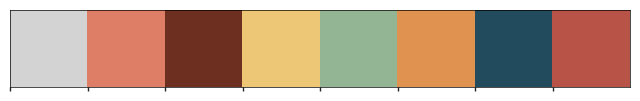

In [134]:
colors = met_brewer.met_brew(name="Hokusai1")
colors.append("lightgrey")
colors = colors[::-1]
sns.palplot(colors)

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_88598/2198771277.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xs, rotation=30, rotation_mode='anchor', ha='right', va='top')
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


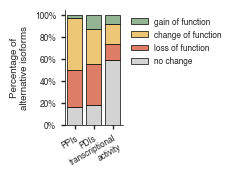

In [135]:
fig, ax = plt.subplots(figsize=(0.75, 1.5))

xs = ["PPIs", "PDIs", "transcriptional\nactivity"]
y1 = list(perc_nonan.loc["no change"])
y2 = list(perc_nonan.loc["loss"])
b2 = np.add(y1, y2)
y3 = list(perc_nonan.loc["change"])
b3 = np.add(b2, y3)
y4 = list(perc_nonan.loc["gain"])

ax.bar(xs, y1, color=colors[0], label="no change", edgecolor="black", linewidth=0.5)
ax.bar(xs, y2, bottom=y1, color=colors[1], label="loss of function", edgecolor="black", linewidth=0.5)
ax.bar(xs, y3, bottom=b2, color=colors[3], label="change of function", edgecolor="black", linewidth=0.5)
ax.bar(xs, y4, bottom=b3, color=colors[4], label="gain of function", edgecolor="black", linewidth=0.5)

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("Percentage of\nalternative isoforms")
ax.set_xticklabels(xs, rotation=30, rotation_mode='anchor', ha='right', va='top')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["%s%%" % x for x in [0, 20, 40, 60, 80, 100]])
ax.set_ylim(0, 1.05)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.xaxis.set_tick_params(length=0)
fig.savefig("../../figures/fig2/Assay_Summary.GainLossChange.pdf", dpi="figure", bbox_inches="tight")

## 13. check riboseq overlap

In [136]:
riboseq_f = "../../data/processed/ribo_seq/counts.RiboSeq.txt"
riboseq = pd.read_table(riboseq_f)

In [137]:
riboseq_samps = [x for x in riboseq.columns if x.startswith("SRR")]
len(riboseq_samps)

77

In [138]:
riboseq["max"] = riboseq[riboseq_samps].max(axis=1)
riboseq["mean"] = riboseq[riboseq_samps].mean(axis=1)
riboseq["median"] = riboseq[riboseq_samps].median(axis=1)

In [139]:
riboseq["chrom"] = riboseq["AltAnalyze_ID"].str.extract(r'(chr[0-9]{1,2}|X|Y|MT):')
riboseq["jx_start"] = riboseq["AltAnalyze_ID"].str.extract(r'chr(?:[0-9]{1,2}|X|Y|MT):(\d+)').astype(int)
riboseq["jx_end"] = riboseq["AltAnalyze_ID"].str.extract(r'-(\d+)$').astype(int)

#### get unique junctions across all isoforms

In [140]:
from itertools import chain
def flatten_set_list(list_of_sets):
    return list(chain.from_iterable(list_of_sets))

In [141]:
# classify all junctions in tfiso1.0 collection by the number of isoforms they are present in
junc_dict = {}
idx = 0

for tf in clone_tfs.keys():
    
    ref = clone_tfs[tf].reference_isoform.name
    iso_juncs_dict = {}
    
    for iso in clone_tfs[tf].isoforms:
        
        iso_juncs = set()
        
        for i in range(len(iso.exons) - 1):
            
            if iso.strand == "+":
                iso_juncs.add((iso.exons[i].end, iso.exons[i+1].start+1))
            if iso.strand == "-":
                iso_juncs.add((iso.exons[i].start+1, iso.exons[i+1].end))
        
        iso_juncs_dict[iso.name] = iso_juncs
    
    # then re-loop
    for iso in clone_tfs[tf].isoforms:
        iso_juncs = iso_juncs_dict[iso.name]
        other_isos = [x for x in iso_juncs_dict.keys() if x != iso.name]
        other_juncs = [iso_juncs_dict[x] for x in other_isos]
        other_juncs = set(flatten_set_list(other_juncs))
        uniq_juncs = iso_juncs.difference(other_juncs)
        if len(uniq_juncs) > 0:
            
            # define iso category
            if iso.name == ref:
                iso_category = "ref"
            elif hasattr(iso, 'is_novel_isoform') and iso.is_novel_isoform():
                iso_category = "novel"
            else:
                iso_category = "alt"
                
            # define iso cloned status
            if hasattr(iso, 'clone_acc'):
                iso_cloned = "cloned"
                clone_acc = iso.clone_acc
            else:
                iso_cloned = "uncloned"
                clone_acc = np.nan
            
                
            for junc in uniq_juncs:
                junc_dict[idx] = {"iso_name": iso.name,
                                  "iso_category": iso_category,
                                  "iso_cloned": iso_cloned,
                                  "clone_acc": clone_acc,
                                  "chrom": clone_tfs[tf].chrom,
                                  "jx_start": junc[0],
                                  "jx_end": junc[1],
                                  "strand": iso.strand}
                idx += 1
            
                
        
        
uniq_junc_df = pd.DataFrame.from_dict(junc_dict, orient="index")
uniq_junc_df.iso_category.value_counts()

iso_category
alt      393
ref      166
novel    114
Name: count, dtype: int64

In [142]:
# merge
riboseq_mrg_uniq = uniq_junc_df.merge(riboseq[riboseq['max'] >= 5], on=['chrom', 'jx_start', 'jx_end'])
len(riboseq_mrg_uniq)

245

In [143]:
riboseq_mrg_uniq.iso_category.value_counts()

iso_category
ref      117
alt      116
novel     12
Name: count, dtype: int64

In [144]:
uniq_junc_df.head()

,iso_name,iso_category,iso_cloned,clone_acc,chrom,jx_start,jx_end,strand
0,ZBTB18-1,ref,cloned,ZBTB18|1/2|04E08,chr1,244051444,244053788,+
1,PRRX1-2,ref,cloned,PRRX1|2/3|09F06,chr1,170726401,170736048,+
2,PRRX1-1,alt,cloned,PRRX1|1/3|09C07,chr1,170726401,170730277,+
3,POU2F1-1,alt,cloned,POU2F1|1/2|03F12,chr1,167329306,167332470,+
4,POU2F1-206,alt,uncloned,NaN,chr1,167372036,167376029,+


In [145]:
tots = pd.DataFrame(uniq_junc_df[["iso_name", "iso_category"]].drop_duplicates().iso_category.value_counts())
present = pd.DataFrame(riboseq_mrg_uniq[["iso_name", "iso_category"]].drop_duplicates().iso_category.value_counts())
perc = tots.join(present, lsuffix='_tot', rsuffix='_present')
perc['percent'] = (perc['count_present']/perc['count_tot'])*100
perc.loc[["ref", "alt", "novel"]]

,count_tot,count_present,percent
iso_category,,,
ref,118,85,72.033898
alt,330,111,33.636364
novel,107,11,10.280374


In [146]:
colors = met_brewer.met_brew(name="VanGogh2")
palette={"ref": colors[2],
         "novel": colors[7],
         "alt": colors[4]}

Palette 'VanGogh2' has '8' discrete colors


In [147]:
perc = perc.reset_index()
perc

,iso_category,count_tot,count_present,percent
0,alt,330,111,33.636364
1,ref,118,85,72.033898
2,novel,107,11,10.280374


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


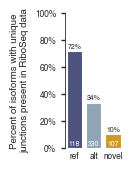

In [148]:
fig = plt.figure(figsize=(0.75, 1.75))
ax = sns.barplot(data=perc, x="iso_category", y="percent",
                 order=["ref", "alt", "novel"], palette=palette)
ax.set_xlabel("")
ax.set_ylabel("Percent of isoforms with unique\njunctions present in RiboSeq data")

perc["iso_category"] = pd.Categorical(perc["iso_category"], categories=["ref", "alt", "novel"], ordered=True)
sorted_perc = perc.sort_values(by=["iso_category"])

for bar, (_, row) in zip(ax.patches, sorted_perc.iterrows()):
    # Percentage value along the top of each bar
    percent = f"{row['percent']:.0f}%"  # Format percentage
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.5,  # Slightly above the bar
        percent, 
        ha="center", va="bottom", fontsize=PAPER_FONTSIZE-2
    )
    
    # n value along the bottom of each bar
    n_value = row["count_tot"]  # Format n-value
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        0,  # bottom of bar
        n_value, 
        color="white",
        ha="center", va="bottom", fontsize=PAPER_FONTSIZE-2
    )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

ax.set_yticks((0, 20, 40, 60, 80, 100))
ax.set_yticklabels(["%s%%" % y for y in ax.get_yticks()])

fig.savefig("../../figures/fig2/RiboSeq_ExpressionQCut_Total.pdf", dpi="figure", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


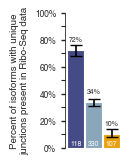

In [150]:
fig = plt.figure(figsize=(0.75, 1.75))
ax = fig.gca()

validation_plot(positives=perc.set_index('iso_category').loc[["ref", "alt", "novel"], 'count_present'].values,
                n_tested=perc.set_index('iso_category').loc[["ref", "alt", "novel"], 'count_tot'].values,
                ax=ax,
                colors=[palette[x] for x in ["ref", "alt", "novel"]],
                errorbar_capsize=0.2,
                bar_spacing=0.05,
                draw_numbers=False,
                )

ax.set_xlabel("")
ax.set_ylabel("Percent of isoforms with unique\njunctions present in Ribo-Seq data")

perc["iso_category"] = pd.Categorical(perc["iso_category"], categories=["ref", "alt", "novel"], ordered=True)
sorted_perc = perc.sort_values(by=["iso_category"])

for bar, (_, row) in zip(ax.patches, sorted_perc.iterrows()):
    # Percentage value along the top of each bar
    percent = f"{row['percent']:.0f}%"  # Format percentage
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.05,  # Slightly above the bar
        percent, 
        ha="center", va="bottom", fontsize=PAPER_FONTSIZE-2
    )
    
    # n value along the bottom of each bar
    n_value = row["count_tot"]  # Format n-value
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        0,  # bottom of bar
        n_value, 
        color="white",
        ha="center", va="bottom", fontsize=PAPER_FONTSIZE-2
    )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f"{y:.0%}" for y in ax.get_yticks()])

fig.savefig("../../figures/fig2/RiboSeq_ExpressionQCut_Total_with-error-bars.pdf", dpi="figure", bbox_inches="tight")

In [151]:
tots = uniq_junc_df[["iso_name", 
                     "iso_cloned", 
                     "iso_category"]].drop_duplicates().groupby(["iso_category", 
                                                                 "iso_cloned"])["iso_name"].agg("count").reset_index()
present = riboseq_mrg_uniq[["iso_name", 
                     "iso_cloned", 
                     "iso_category"]].drop_duplicates().groupby(["iso_category", "iso_cloned"])["iso_name"].agg("count").reset_index()
perc_all = tots.merge(present, on=["iso_category", "iso_cloned"], how="left", suffixes=("_tot", "_present"))
perc_all["percent"] = (perc_all["iso_name_present"]/perc_all["iso_name_tot"])*100
perc_all.sort_values(by="percent", ascending=False)

,iso_category,iso_cloned,iso_name_tot,iso_name_present,percent
3,ref,cloned,91,69,75.824176
4,ref,uncloned,27,16,59.259259
0,alt,cloned,130,60,46.153846
1,alt,uncloned,200,51,25.500000
2,novel,cloned,107,11,10.280374


In [152]:
riboseq_mrg_uniq[riboseq_mrg_uniq['iso_category'] == 'novel'][['iso_name', 'chrom', 'jx_start',
                                                               'jx_end', 'AltAnalyze_ID']]

,iso_name,chrom,jx_start,jx_end,AltAnalyze_ID
5,LHX9-2,chr1,197920174,197921307,ENSG00000143355:E6.1-E7.1_197921307=chr1:19792...
27,NR4A2-2,chr2,156326718,156326207,ENSG00000153234:E8.1-E9.3=chr2:156326718-15632...
51,MXD3-4,chr5,177311379,177310540,ENSG00000213347:E3.2-E5.1=chr5:177311379-17731...
55,ZKSCAN3-1,chr6,28359901,28361324,ENSG00000189298:E3.1_28359901-E4.1=chr6:283599...
108,ZNF250-2,chr8,144889581,144882836,ENSG00000196150:E32.8-E41.1=chr8:144889581-144...
174,ZNF280D-1,chr15,56654385,56653599,ENSG00000285253:E29.1-E30.1=chr15:56654385-566...
193,MLX-2,chr17,42570172,42571547,ENSG00000108788:E3.8_42570172-E4.1=chr17:42570...
202,SMAD4-1,chr18,51076776,51077307,ENSG00000141646:E15.1-E16.4=chr18:51076776-510...
223,ZNF264-2,chr19,57194001,57211354,ENSG00000083844:E2.2-E5.1=chr19:57194001-57211354
224,ZNF430-1,chr19,21034184,21378629,ENSG00000118620:E4.2-ENSG00000172687:E14.4=chr...


In [153]:
# try and subset by max expression
mm["max_dev_qcut"] = pd.qcut(mm["max_dev"], q=4, labels=list(range(1, 5)))
mm["max_gtex_ds_qcut"] = pd.qcut(mm["max_gtex_ds"], q=4, labels=list(range(1, 5)))
mm["med_dev_qcut"] = pd.qcut(mm["median_dev"], q=4, labels=list(range(1, 5)))
mm["med_gtex_ds_qcut"] = pd.qcut(mm["median_gtex_ds"], q=4, labels=list(range(1, 5)))

def extract_name(row, col):
    if "noclone" in row[col]:
        iso_name = row[col].split(" ")[1].split("_")[0]
    else:
        clone_acc = row[col].split(" ")[0]
        iso_name = clone_acc.split("|")[0] + "-" + clone_acc.split("|")[1].split("/")[0]
    return iso_name

mm["iso_name"] = mm.apply(extract_name, axis=1, col="UID_dev")

In [154]:
status_map["iso_name"] = status_map.apply(extract_name, axis=1, col="clone_acc")

In [155]:
status_map.status.value_counts()

status
alt      333
novel    183
ref      177
Name: count, dtype: int64

In [156]:
mm = mm.merge(status_map[["iso_name", "status"]], on="iso_name")
len(mm)

695

In [157]:
# now, iterate through the bins and calculate percent of isoforms that show junction-level translation
qcut_percs = pd.DataFrame()

for col in ["max_dev", "max_gtex_ds", "med_dev", "med_gtex_ds"]:
    col_qcut = "%s_qcut" % col
    
    for qcut in range(1, 5):
        print("QUARTILE: %s" % (qcut))

        mm_sub = mm[mm[col_qcut] == qcut]
        print("num isos in qcut: %s" % len(mm_sub))

        mm_sub_w_jx = mm_sub.merge(uniq_junc_df[["iso_name", "chrom", "jx_start", "jx_end"]], 
                                   on=["iso_name"])
        print("num unique junctions in qcut: %s" % len(mm_sub_w_jx))
        
        # filter for riboseq junctions with at least 5 reads
        ribo_seq_sub_w_jx = mm_sub_w_jx.merge(riboseq[riboseq['max'] >= 5][["chrom", "jx_start", "jx_end",
                                                                            "max", "median"]],
                                              on=["chrom", "jx_start", "jx_end"])
        print("num junctions in riboseq: %s" % len(ribo_seq_sub_w_jx))


        tots = mm_sub_w_jx[["iso_name", "status"]].drop_duplicates().groupby(["status"])["iso_name"].agg("count").reset_index()
        present = ribo_seq_sub_w_jx[["iso_name", "status"]].drop_duplicates().groupby(["status"])["iso_name"].agg("count").reset_index()
        perc = tots.merge(present, on=["status"], 
                          how="left", suffixes=("_tot", "_present"))
        perc["percent"] = (perc["iso_name_present"]/perc["iso_name_tot"])*100
        perc["qcut"] = qcut
        perc["col"] = col

        qcut_percs = pd.concat([qcut_percs, perc])
        
qcut_percs.head()

QUARTILE: 1
num isos in qcut: 174
num unique junctions in qcut: 84
num junctions in riboseq: 14
QUARTILE: 2
num isos in qcut: 174
num unique junctions in qcut: 89
num junctions in riboseq: 36
QUARTILE: 3
num isos in qcut: 173
num unique junctions in qcut: 106
num junctions in riboseq: 44
QUARTILE: 4
num isos in qcut: 174
num unique junctions in qcut: 107
num junctions in riboseq: 75
QUARTILE: 1
num isos in qcut: 174
num unique junctions in qcut: 85
num junctions in riboseq: 11
QUARTILE: 2
num isos in qcut: 174
num unique junctions in qcut: 87
num junctions in riboseq: 31
QUARTILE: 3
num isos in qcut: 173
num unique junctions in qcut: 113
num junctions in riboseq: 56
QUARTILE: 4
num isos in qcut: 174
num unique junctions in qcut: 101
num junctions in riboseq: 71
QUARTILE: 1
num isos in qcut: 174
num unique junctions in qcut: 75
num junctions in riboseq: 10
QUARTILE: 2
num isos in qcut: 174
num unique junctions in qcut: 100
num junctions in riboseq: 22
QUARTILE: 3
num isos in qcut: 173
n

,status,iso_name_tot,iso_name_present,percent,qcut,col
0,alt,26,7,26.923077,1,max_dev
1,novel,48,4,8.333333,1,max_dev
2,ref,5,3,60.000000,1,max_dev
0,alt,38,21,55.263158,2,max_dev
1,novel,31,2,6.451613,2,max_dev


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


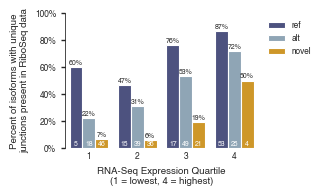

In [158]:
fig = plt.figure(figsize=(2.5, 1.75))
ax = sns.barplot(data=qcut_percs[qcut_percs["col"] == "med_dev"], x="qcut", hue="status", y="percent",
                 hue_order=["ref", "alt", "novel"], palette=palette)
ax.set_xlabel("RNA-Seq Expression Quartile\n(1 = lowest, 4 = highest)")
ax.set_ylabel("Percent of isoforms with unique\njunctions present in RiboSeq data")
plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

# Make 'qcut' and 'status' columns categorical
qcut_percs["status"] = pd.Categorical(qcut_percs["status"], categories=["ref", "alt", "novel"], ordered=True)
sorted_qcuts = qcut_percs.sort_values(by=["status", "qcut"])

for bar, (_, row) in zip(ax.patches, sorted_qcuts[sorted_qcuts["col"] == "med_dev"].iterrows()):
    # Percentage value along the top of each bar
    percent = f"{row['percent']:.0f}%"  # Format percentage
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.5,  # Slightly above the bar
        percent, 
        ha="center", va="bottom", fontsize=PAPER_FONTSIZE-2
    )
    
    # n value along the bottom of each bar
    n_value = row["iso_name_tot"]  # Format n-value
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        0,  # bottom of bar
        n_value, 
        color="white",
        ha="center", va="bottom", fontsize=PAPER_FONTSIZE-2
    )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

ax.set_yticks((0, 20, 40, 60, 80, 100))
ax.set_yticklabels(["%s%%" % y for y in ax.get_yticks()])

fig.savefig("../../figures/fig2/RiboSeq_ExpressionQCut_MedDev.pdf", dpi="figure", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


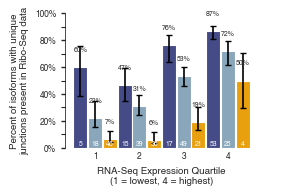

In [163]:
fig = plt.figure(figsize=(2.5, 1.75))
ax = fig.gca()

#ax = sns.barplot(data=qcut_percs[qcut_percs["col"] == "med_dev"], x="qcut", hue="status", y="percent",
#                 hue_order=["ref", "alt", "novel"], palette=palette)

pos = [qcut_percs.loc[(qcut_percs['col'] == 'med_dev') 
                       & (qcut_percs['status'] == i) 
                       & (qcut_percs['qcut'] == j), 'iso_name_present'].values[0] 
                       for j in range(1, 5)
                       for i in ["ref", "alt", "novel"]
                       ]
tot = [qcut_percs.loc[(qcut_percs['col'] == 'med_dev') 
                       & (qcut_percs['status'] == i) 
                       & (qcut_percs['qcut'] == j), 'iso_name_tot'].values[0] 
                       for j in range(1, 5)
                       for i in ["ref", "alt", "novel"]]

validation_plot(
    positives=pos,
    n_tested=tot,
    ax=ax,
    bar_spacing=0.05,
    draw_numbers=False,
    errorbar_capsize=0.03,
    colors=[palette[x] for x in ["ref", "alt", "novel"]] * 4,
)

ax.set_xlabel("RNA-Seq Expression Quartile\n(1 = lowest, 4 = highest)")
ax.set_ylabel("Percent of isoforms with unique\njunctions present in Ribo-Seq data")
plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

# Make 'qcut' and 'status' columns categorical
qcut_percs["status"] = pd.Categorical(qcut_percs["status"], categories=["ref", "alt", "novel"], ordered=True)
sorted_qcuts = qcut_percs.sort_values(by=["qcut", "status"])

for bar, (_, row) in zip(ax.patches, sorted_qcuts[sorted_qcuts["col"] == "med_dev"].iterrows()):
    # Percentage value along the top of each bar
    percent = f"{row['percent']:.0f}%"  # Format percentage
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.1,  # Slightly above the bar
        percent, 
        ha="center", va="bottom", fontsize=PAPER_FONTSIZE-2
    )
    
    # n value along the bottom of each bar
    n_value = row["iso_name_tot"]  # Format n-value
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        0,  # bottom of bar
        n_value, 
        color="white",
        ha="center", va="bottom", fontsize=PAPER_FONTSIZE-2
    )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xticks([1, 4, 7, 10])
ax.set_xticklabels([1, 2, 3, 4])


ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f"{y:.0%}" for y in ax.get_yticks()])

fig.savefig("../../figures/fig2/RiboSeq_ExpressionQCut_MedDev_with-error-bars.pdf", dpi="figure", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


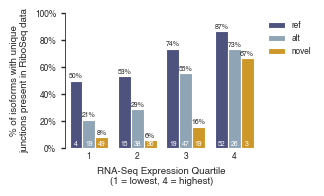

In [165]:
fig = plt.figure(figsize=(2.5, 1.75))
ax = sns.barplot(data=qcut_percs[qcut_percs["col"] == "med_gtex_ds"], x="qcut", hue="status", y="percent",
                 hue_order=["ref", "alt", "novel"], palette=palette)
ax.set_xlabel("RNA-Seq Expression Quartile\n(1 = lowest, 4 = highest)")
ax.set_ylabel("% of isoforms with unique\njunctions present in RiboSeq data")
plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

# Make 'qcut' and 'status' columns categorical
qcut_percs["status"] = pd.Categorical(qcut_percs["status"], categories=["ref", "alt", "novel"], ordered=True)
sorted_qcuts = qcut_percs.sort_values(by=["status", "qcut"])

for bar, (_, row) in zip(ax.patches, sorted_qcuts[sorted_qcuts["col"] == "med_gtex_ds"].iterrows()):
    # Percentage value along the top of each bar
    percent = f"{row['percent']:.0f}%"  # Format percentage
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.5,  # Slightly above the bar
        percent, 
        ha="center", va="bottom", fontsize=PAPER_FONTSIZE-2
    )
    
    # n value along the bottom of each bar
    n_value = row["iso_name_tot"]  # Format n-value
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        0,  # bottom of bar
        n_value, 
        color="white",
        ha="center", va="bottom", fontsize=PAPER_FONTSIZE-2
    )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

ax.set_yticks((0, 20, 40, 60, 80, 100))
ax.set_yticklabels(["%s%%" % y for y in ax.get_yticks()])

fig.savefig("../../figures/fig2/RiboSeq_ExpressionQCut_MedGtexDS.pdf", dpi="figure", bbox_inches="tight")

## 14. make supplemental files

### Clone List

In [166]:
supp_clones = {}

for gene in clone_tfs:
    gene_ref = clone_tfs[gene].cloned_reference_isoform.name
    for iso in clone_tfs[gene].cloned_isoforms:
        clone_name = iso.name
        if not iso.ensembl_transcript_names is None:
            tx_names = "|".join(iso.ensembl_transcript_names)
            tx_ids = "|".join(iso.ensembl_transcript_ids)
            if clone_name == gene_ref:
                status = "annotated reference"
            else:
                status = "annotated alternative"
        else:
            tx_names = "NA"
            tx_ids = "NA"
            
            if clone_name == gene_ref:
                status = "novel reference"
            else:
                status = "novel alternative"
        cds_seq = iso.clone_nt_seq
        aa_seq = iso.aa_seq
        supp_clones[clone_name] = {"gene_symbol": gene, 
                                   "isoform_status": status,
                                   "gencode_transcript_names": tx_names,
                                   "ensembl_transcript_ids": tx_ids, 
                                   "cds_seq": cds_seq,
                                   "aa_seq": aa_seq}
        
supp_clones = pd.DataFrame.from_dict(supp_clones, 
                                     orient="index").rename_axis("clone_id").reset_index()
supp_clones["isoform_status"] = pd.Categorical(supp_clones["isoform_status"], 
                                       ["annotated reference", "novel reference", 
                                        "annotated alternative",
                                        "novel alternative"])
supp_clones["tf_family"] = supp_clones["gene_symbol"].map(fam)

supp_clones = supp_clones.sort_values(by=["clone_id", "isoform_status"])
print("NUMBER OF ISOS IN SUPP FILE: %s" % (len(supp_clones.clone_id.unique())))
print("NUMBER OF GENES IN SUPP FILE: %s" % (len(supp_clones.gene_symbol.unique())))
supp_clones.isoform_status.value_counts()

NUMBER OF ISOS IN SUPP FILE: 693
NUMBER OF GENES IN SUPP FILE: 246


isoform_status
annotated alternative    275
annotated reference      235
novel alternative        172
novel reference           11
Name: count, dtype: int64

In [167]:
supp_clones.to_csv("../../supp/SuppTable_CloneList.txt", index=False, sep="\t")

In [168]:
supp_clones.head()

,clone_id,gene_symbol,isoform_status,gencode_transcript_names,ensembl_transcript_ids,cds_seq,aa_seq,tf_family
388,AEBP2-2,AEBP2,novel reference,NA,NA,ATGGATGTAGACAGCACAATTTCCAGTGGGCGTTCAACTCCAGCAA...,MDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYNCCWDQCQACFNSS...,C2H2 ZF
389,AEBP2-3,AEBP2,novel alternative,NA,NA,ATGTACACACGTCGGTACTCAAGCATAAGCAGTACTATAATGGATG...,MYTRRYSSISSTIMDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYN...,C2H2 ZF
455,ARNT2-1,ARNT2,annotated reference,ARNT2-201,ENST00000303329,ATGGCAACCCCGGCGGCGGTCAACCCTCCGGAAATGGCTTCAGACA...,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,bHLH
457,ARNT2-2,ARNT2,novel alternative,NA,NA,ATGGCTTCAGACATACCTGGATCTGTGACGTTGCCCGTTGCCCCCA...,MASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKRRSGMDFDDEDG...,bHLH
456,ARNT2-3,ARNT2,annotated alternative,ARNT2-209,ENST00000622346,ATGGCAACCCCGGCGGCGGTCAACCCTCCGGAAATGGCTTCAGACA...,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,bHLH


### DNA baits in Y1H

In [169]:
len(baits)

186

In [170]:
supp_baits = load_Y1H_DNA_bait_sequences()
supp_baits = (pd.DataFrame.from_dict(supp_baits, orient="index")
              .rename_axis("bait_id")
              .reset_index())
supp_baits.columns = ["bait_id", "seq"]
supp_baits["bait_id"] = supp_baits["bait_id"].str.upper()

# limit to baits that are in our y1h data
supp_baits = supp_baits[supp_baits["bait_id"].isin(baits)]
print("NUM OF BAITS IN SUPP FILE: %s" % len(supp_baits))

supp_baits.to_csv("../../supp/SuppTable_DNABaits.txt", index=False, sep="\t")

NUM OF BAITS IN SUPP FILE: 186


### Y1H results

In [171]:
# map clone_acc to clone_name
clone_acc_map = {}

for gene in clone_tfs:
    for iso in clone_tfs[gene].cloned_isoforms:
        clone_acc = iso.clone_acc
        clone_name = iso.name
        clone_acc_map[clone_acc] = clone_name

In [172]:
supp_y1h = y1h.copy()
supp_y1h["clone_id"] = supp_y1h["clone_acc"].map(clone_acc_map)
supp_y1h = supp_y1h[["gene_symbol", "clone_id"] + baits]

print("NUM ISOS IN SUPP Y1H FILE: %s" % (len(supp_y1h.clone_id.unique())))
print("NUM GENES IN SUPP Y1H FILE: %s" % (len(supp_y1h.gene_symbol.unique())))
print("NUM BAITS IN SUPP Y1H FILE: %s" % len(baits))
supp_y1h

NUM ISOS IN SUPP Y1H FILE: 171
NUM GENES IN SUPP Y1H FILE: 80
NUM BAITS IN SUPP Y1H FILE: 186


,gene_symbol,clone_id,HS1006,HS1022,HS1043,HS1067,HS1139,HS1142,HS118,HS1181,...,KITLG,LTA,PF4V1,TNFSF10,TNFSF13,TNFSF14,TNFSF4,TNFSF8,XCL1,XCL2
0,CREB1,CREB1-1,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,CREB1,CREB1-2,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,DLX1,DLX1-1,False,False,False,<NA>,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,DLX1,DLX1-2,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,DLX4,DLX4-1,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,ZNF18,ZNF18-3,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
169,ZNF320,ZNF320-1,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
170,ZNF438,ZNF438-1,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
171,ZNF438,ZNF438-2,False,False,False,False,False,False,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [173]:
supp_y1h.to_csv("../../supp/SuppTable_eY1HResults.txt", index=False, sep="\t")

### Y2H results

In [174]:
supp_y2h = load_full_y2h_data_including_controls()
supp_y2h.head()

,large_plate_name,retest_pla,retest_pos,ad_gene_symbol,ad_clone_name,ad_orf_id,db_gene_symbol,db_orf_id,category,3AT,LW,empty_AD_3AT,empty_AD_LW,Y2H_result,seq_confirmation_3AT,seq_confirmation_LW,ad_clone_acc
0,TFfnlr07_001_002_003_004_005_006,5,A01,ATF2,ATF2-1,101414,ATF2,54731,tf_isoform_ppis,2,4,0,4,True,True,True,ATF2|1/6|12H04
1,TFfnlr07_001_002_003_004_005_006,5,A02,ATF2,ATF2-1,101414,COL8A1,3053,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|1/6|12H04
2,TFfnlr07_001_002_003_004_005_006,5,A03,ATF2,ATF2-1,101414,EFEMP2,2906,tf_paralog_ppis,0,4,0,4,False,NaN,True,ATF2|1/6|12H04
3,TFfnlr07_001_002_003_004_005_006,5,A04,ATF2,ATF2-1,101414,FOSL2,12504,tf_isoform_ppis,2,4,0,4,NaN,False,True,ATF2|1/6|12H04
4,TFfnlr07_001_002_003_004_005_006,5,A05,ATF2,ATF2-1,101414,JDP2,13624,tf_isoform_ppis,2,4,0,4,True,True,True,ATF2|1/6|12H04


In [175]:
# reload y2h since we loaded validation data above
supp_y2h = load_full_y2h_data_including_controls()
supp_y2h = supp_y2h.rename(columns={'ad_clone_name': 'ad_clone_id'})
clones = load_valid_isoform_clones(include_single_isoform_genes=True)
supp_y2h = supp_y2h.loc[
    ~supp_y2h["category"].isin(["lit_bm_isoforms", "rrs_isoforms"])
    & supp_y2h['ad_clone_acc'].isin(clones["clone_acc"].values),
    [
     'ad_clone_id',
     'ad_gene_symbol',
     'ad_orf_id',
     'db_gene_symbol',
     'db_orf_id',
     'Y2H_result',
     ]
]
print("NUM ISOS IN SUPP Y2H FILE: %s" % (len(supp_y2h["ad_clone_id"].unique())))
print("NUM GENES IN SUPP Y2H FILE: %s" % (len(supp_y2h['ad_gene_symbol'].unique())))
print("NUM PARTNERS IN SUPP Y2H FILE: %s" % len(supp_y2h['db_gene_symbol'].unique()))
supp_y2h.head()

NUM ISOS IN SUPP Y2H FILE: 306
NUM GENES IN SUPP Y2H FILE: 105
NUM PARTNERS IN SUPP Y2H FILE: 753


,ad_clone_id,ad_gene_symbol,ad_orf_id,db_gene_symbol,db_orf_id,Y2H_result
0,ATF2-1,ATF2,101414,ATF2,54731,True
1,ATF2-1,ATF2,101414,COL8A1,3053,False
2,ATF2-1,ATF2,101414,EFEMP2,2906,False
3,ATF2-1,ATF2,101414,FOSL2,12504,NaN
4,ATF2-1,ATF2,101414,JDP2,13624,True


In [176]:
# add the categories
cats = load_ppi_partner_categories()
cats.columns = ["db_gene_symbol", "db_gene_category", "db_gene_cofactor_type"]
supp_y2h = supp_y2h.merge(cats, on="db_gene_symbol", how="left")
supp_y2h[pd.isnull(supp_y2h["db_gene_category"])]

reading from cache
reading from cache


,ad_clone_id,ad_gene_symbol,ad_orf_id,db_gene_symbol,db_orf_id,Y2H_result,db_gene_category,db_gene_cofactor_type


In [177]:
supp_y2h.sample(5)

,ad_clone_id,ad_gene_symbol,ad_orf_id,db_gene_symbol,db_orf_id,Y2H_result,db_gene_category,db_gene_cofactor_type
1426,ZKSCAN1-2,ZKSCAN1,101134,ZNF446,6131,False,TF,NaN
889,ZBTB25-1,ZBTB25,101388,JUNB,4265,False,TF,NaN
326,FOXP2-1,FOXP2,101203,ZFHX3,9406,True,TF,NaN
5548,TCF4-2,TCF4,100460,TSSK3,9272,True,signaling,NaN
7898,PATZ1-2,PATZ1,101008,RBM10,4573,NaN,other,NaN


In [178]:
supp_y2h.db_gene_category.value_counts()

db_gene_category
other        3602
TF           2794
signaling    1936
cofactor     1230
Name: count, dtype: int64

In [179]:
supp_y2h.db_gene_cofactor_type.value_counts()

db_gene_cofactor_type
unknown        811
corepressor    170
coactivator    168
both            81
Name: count, dtype: int64

In [180]:
supp_y2h.to_csv("../../supp/SuppTable_PairwiseY2HResults.txt", index=False, sep="\t")

### M1H results

In [181]:
# reload m1h since we summarized above
m1h = load_m1h_activation_data()
m1h['M1H_mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
supp_m1h = m1h.copy()
supp_m1h["clone_id"] = supp_m1h["clone_acc"].map(clone_acc_map)
supp_m1h = supp_m1h[["clone_id", "gene_symbol", "M1H_rep1", "M1H_rep2", "M1H_rep3", "M1H_mean"]]

print("NUM ISOS IN SUPP M1H FILE: %s" % (len(supp_m1h.clone_id.unique())))
print("NUM GENES IN SUPP M1H FILE: %s" % (len(supp_m1h.gene_symbol.unique())))
supp_m1h.head()

NUM ISOS IN SUPP M1H FILE: 581
NUM GENES IN SUPP M1H FILE: 264


,clone_id,gene_symbol,M1H_rep1,M1H_rep2,M1H_rep3,M1H_mean
360,AEBP2-2,AEBP2,0.241019,0.189211,0.473661,0.301297
359,AEBP2-3,AEBP2,-0.276303,-0.305477,-0.121186,-0.234322
0,ARNT2-1,ARNT2,4.498733,4.501519,4.297244,4.432498
1,ARNT2-2,ARNT2,2.407721,2.407411,2.197963,2.337698
3,ARNTL2-2,ARNTL2,0.398027,0.391809,0.299461,0.363099


In [182]:
supp_m1h.to_csv("../../supp/SuppTable_M1HResults.txt", index=False, sep="\t")

### PPI validation

In [183]:
supp_n2h = load_n2h_ppi_validation_data()

supp_n2h["clone_id"] = supp_n2h["clone_acc"].map(clone_acc_map)


# drop vignettes, since we don't use them
# unless we change and use it to mention CREB5-MAPK9
supp_n2h = supp_n2h.loc[
    ~supp_n2h['source'].isin({'vignettes'}),
    [
        'clone_id', 
        'gene_symbol_tf',
        'gene_symbol_partner',
        'test_orf_ida',
        'test_orf_idb',
        'source',
        'score_pair',
        'score_empty-N1',
        'score_empty-N2',
        'log2 NLR',
    ]
]


supp_n2h.to_csv("../../supp/SuppTable_N2HResults.txt",
                index=False,
                sep="\t")

### PDI validation

In [184]:
supp_pdi_val = load_PDI_luciferase_validation_experiment()
y1h = load_y1h_pdi_data()

# update the interaction calls if needed
new_calls = []
for i, row in supp_pdi_val.iterrows():
    clone = row["clone_acc"]
    bait = row["Bait"]
    orig_y1h_call = row['Interaction?']
    
    try:
        updated_y1h_call = y1h[y1h['clone_acc'] == clone][bait].iloc[0]
    except:
        print("not found: clone: %s | bait: %s | orig call: %s" % (clone, bait, orig_y1h_call))
        updated_y1h_call = np.nan
    new_calls.append(updated_y1h_call)

supp_pdi_val["Y1H_result"] = new_calls
supp_pdi_val["clone_id"] = supp_pdi_val["clone_acc"].map(clone_acc_map)
supp_pdi_val = supp_pdi_val.loc[pd.notnull(supp_pdi_val['Y1H_result']), 
    [
        "gene_symbol",
        "clone_id",
        "Bait",
        "Y1H_result",
        'Replicate1', 
        'Replicate2',
        'Replicate3', 
        'Average (empty-pEZY3-VP160)',
        'Log2(FC)',
    ]
]
supp_pdi_val.to_csv("../../supp/SuppTable_PDI_validation.txt",
                index=False,
                sep="\t")


not found: clone: HNF1B|4/4|05E06 | bait: HS565 | orig call: no
not found: clone: HNF4A|6/6|10F07 | bait: HS1315 | orig call: no
not found: clone: HNF4A|6/6|10F07 | bait: HS20 | orig call: no
not found: clone: LCOR|1/2|09G02 | bait: HS118 | orig call: no
not found: clone: LCOR|1/2|09G02 | bait: HS586 | orig call: no
not found: clone: SOX15|2/2|08F12 | bait: HS1181 | orig call: no
not found: clone: SOX15|2/2|08F12 | bait: HS796 | orig call: no
not found: clone: THRA|3/3|09B09 | bait: HS1185 | orig call: no
not found: clone: THRA|3/3|09B09 | bait: HS204 | orig call: no
not found: clone: HNF1B|4/4|05E06 | bait: HS863 | orig call: yes
not found: clone: LCOR|1/2|09G02 | bait: HS1022 | orig call: yes
not found: clone: TBX6|1/2|03G06 | bait: HS2081 | orig call: yes
not found: clone: TBX6|1/2|03G06 | bait: HS416 | orig call: yes


### Pfam domains considered DNA binding

In [185]:
supp_dbd = load_DNA_binding_domains()
supp_dbd.to_csv("../../supp/SuppTable_DBD_definition.txt",
                index=False,
                sep="\t")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


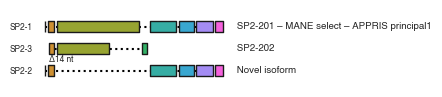

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 1))

clone_tfs["SP2"].exon_diagram(ax=ax)
fig.savefig("../../figures/fig2/SP2_exons.pdf", dpi="figure", bbox_inches="tight")